#### 1. Geometry of Vectors

Vectors can be interpreted in two ways:

- **As points** in space, representing positions relative to an origin.
- **As directions**, representing displacements from the origin or between points.  

A vector $\mathbf{x}$ can be written as a **column**:
$\mathbf{x} = \begin{bmatrix} x_1 \ x_2 \ \vdots \ x_n \end{bmatrix}$

or as its **transpose (row vector)**:
$\mathbf{x}^\top = \begin{bmatrix} x_1 & x_2 & \dots & x_n \end{bmatrix}$

These are two representations of the same list of numbers.

#### 2. Dot Products and Angles

The **dot product** of two vectors $\mathbf{u}$ and $\mathbf{v}$ is:
$\mathbf{u} \cdot \mathbf{v} = \sum_i u_i v_i$

This operation is symmetric and relates directly to geometry:
$\mathbf{u} \cdot \mathbf{v} = |\mathbf{u}| |\mathbf{v}| \cos\theta$

where $\theta$ is the angle between the vectors. From this, we get:
$\theta = \arccos\left(\frac{\mathbf{u}\cdot\mathbf{v}}{|\mathbf{u}||\mathbf{v}|}\right)$

This holds in any dimension, not just two or three.

#### Cosine Similarity

A common machine-learning quantity derived from the dot product is **cosine similarity**:

cosine_similarity $(\mathbf{u},\mathbf{v}) = \frac{\mathbf{u}\cdot\mathbf{v}}{|\mathbf{u}||\mathbf{v}|}$

It measures directional similarity between vectors regardless of magnitude.



In [2]:
# compute the angle between a pair of vectors:

%matplotlib inline
import torch
import torchvision
from IPython import display
from torchvision import transforms
from d2l import torch as d2l


def angle(v, w):
    return torch.acos(v.dot(w) / (torch.norm(v) * torch.norm(w)))

angle(torch.tensor([0, 1, 2], dtype=torch.float32), torch.tensor([2.0, 3, 4]))

tensor(0.4190)

#### 3. Hyperplanes

A **hyperplane** in $d$-dimensional space is the set of points satisfying a linear equation:
$\mathbf{w}\cdot\mathbf{x} = c$

- In 2D, this is a line.
- In 3D, it’s a plane.
- In $d$ dimensions, it has $d{-}1$ dimensions.

The **inequalities** $\mathbf{w}\cdot\mathbf{x} > c$ and $\mathbf{w}\cdot\mathbf{x} < c$ define two **half-spaces** separated by the hyperplane.  
- 2D:
![2D- 1](./Images/22/2d-hyperplane.png)
![2D- 2](./Images/22/2d-hyperplane2.png)
- High dimension
![high-dim](./Images/22/high-dim-hyperplane.png)


In [27]:
# Load in the dataset
trans = []
trans.append(transforms.ToTensor())
trans = transforms.Compose(trans)
train = torchvision.datasets.FashionMNIST(root="../data", transform=trans,
                                          train=True, download=True)
test = torchvision.datasets.FashionMNIST(root="../data", transform=trans,
                                         train=False, download=True)
type(train)

torchvision.datasets.mnist.FashionMNIST

In [4]:
print(train[0][0].shape) # (1, 28, 28): 1 channel (grayscale), 28×28 pixels
print(train[0][1]) # label 9 (Ankle boot)

torch.Size([1, 28, 28])
9


In [29]:
# x[0] - The image tensor (1*28*28 pixels)
# x[1] - The label (0-9 for different clothing types)
# if x[1] == 0 - Filters only images with label 0 (T-shirts)
# if x[1] == 1 - Filters only images with label 1 (Trousers)
# * 256 - Scales pixel values from [0,1] back to [0,255] range
# torch.stack(...) - Combines all filtered images into a single tensor

# X_train_0 → all T-shirt images from training set: [6000, 1, 28, 28]
X_train_0 = torch.stack(
    [x[0] * 256 for x in train if x[1] == 0]).type(torch.float32)

# X_train_1 → all Trouser images from training set: [6000, 1, 28, 28] 
X_train_1 = torch.stack(
    [x[0] * 256 for x in train if x[1] == 1]).type(torch.float32)

# X_test → all T-shirt and Trouser images from test set: [2000, 1, 28, 28]
X_test = torch.stack(
    [x[0] * 256 for x in test if x[1] == 0 or x[1] == 1]).type(torch.float32)

# y_test → labels (0 or 1) for all T-shirt and Trouser images from test set: [2000]
y_test = torch.stack(
    [torch.tensor(x[1]) for x in test if x[1] == 0 or x[1] == 1]).type(torch.float32)


# Compute averages
ave_0 = torch.mean(X_train_0, axis=0)
ave_1 = torch.mean(X_train_1, axis=0)

print(X_train_0.shape) # (6000, 1, 28, 28)
print(X_train_1.shape) # (6000, 1, 28, 28)
print(X_test.shape) # (2000, 1, 28, 28)
print(y_test.shape) # (2000)
print(ave_0.shape)  # (1, 28, 28)
print(ave_1.shape)  # (1, 28, 28)

torch.Size([6000, 1, 28, 28])
torch.Size([6000, 1, 28, 28])
torch.Size([2000, 1, 28, 28])
torch.Size([2000])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


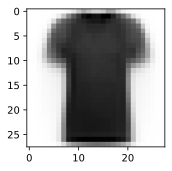

In [30]:
# Plot average t-shirt
d2l.set_figsize()
d2l.plt.imshow(ave_0.reshape(28, 28).tolist(), cmap='Greys')
d2l.plt.show()

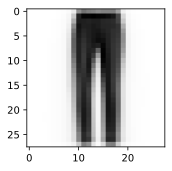

In [7]:
# Plot average trousers
d2l.plt.imshow(ave_1.reshape(28, 28).tolist(), cmap='Greys')
d2l.plt.show()

In [ ]:
# The weight vector (difference between average trouser and T-shirt)
# w: (1, 28, 28).T = (28, 28, 1)
w = (ave_1 - ave_0).T

# X_test.reshape(2000, -1) flattens each 28x28 image into a vector of size 784: (2000, 784)
# In a fully machine learned solution, we would learn the threshold from the dataset. 
# In this case, I simply eyeballed a threshold that looked good on the training data by hand.

# w: direction from T-shirt to Trouser in 784-dimensional pixel space.
# image @ w, you're measuring how much the image aligns with that direction.
#
# Hyperplane Decision Boundary (perpendicular to w):
#
#                          |
#         T-shirt side     |      Trouser side
#           (x·w < c)      |       (x·w > c)
#                          |
#     ●                    |                    ●
#   ave_0                  |                  ave_1
# (T-shirt)                |                (Trouser)
#                          |
#     ─────────────────────┼─────────────────────→  w (weight direction)
#                          |
#                     threshold (c)
#                    (hyperplane)
#
# The hyperplane x·w = c divides the space into two half-spaces.
# Points with x·w > c are classified as Trouser (label 1).
# Points with x·w < c are classified as T-shirt (label 0).

#: (2000, 28*28) @ (28*28*1) -> (2000)
predictions = X_test.reshape(2000, -1) @ (w.flatten()) > -1500000

# Accuracy
torch.mean((predictions.type(y_test.dtype) == y_test).float(), dtype=torch.float64)

/tmp/ipykernel_2247/1381869222.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  w = (ave_1 - ave_0).T


tensor(0.7870, dtype=torch.float64)

#### 4. Geometry of Linear Transformations

Matrices represent **linear transformations** from one vector space to another. Conceptually, they manipulate lengths and directions, and their action can be visualized by seeing how they distort shapes such as grids or parallelograms.

The matrix multiplication can skew, rotate, and scale the grid, but the grid structure must remain:

![matrix transformation](./Images/22/matrix-transformation.png)

##### Types of Linear Transformations

**1. Scaling** — Stretches or compresses along axes

A scaling matrix multiplies each coordinate by a factor:
$$
\begin{bmatrix} s_x & 0 \\ 0 & s_y \end{bmatrix}
$$
- $s_x > 1$: stretch horizontally
- $s_x < 1$: compress horizontally  
- $s_x = s_y$: uniform scaling (zoom in/out)
- Negative values also flip (reflect)

**2. Rotation** — Turns vectors around the origin

A rotation matrix by angle $\theta$ (counterclockwise):
$$
\begin{bmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{bmatrix}
$$
- Preserves lengths and angles
- Determinant = 1 (no area change)
- Orthogonal matrix: $R^T R = I$

**3. Shear (Skew)** — Slants the grid while keeping one axis fixed

A horizontal shear:
$$
\begin{bmatrix} 1 & k \\ 0 & 1 \end{bmatrix}
$$
- Slides points horizontally proportional to their $y$-coordinate
- Vertical lines become slanted, horizontal lines stay horizontal
- Determinant = 1 (preserves area)

A vertical shear:
$$
\begin{bmatrix} 1 & 0 \\ k & 1 \end{bmatrix}
$$

##### Visual Summary

| Transform | Effect on Grid | Preserves |
|-----------|---------------|-----------|
| **Scale** | Stretches/compresses along axes | Axis directions |
| **Rotate** | Turns around origin | Lengths, angles, area |
| **Shear** | Slants in one direction | One axis, area |

##### Composition & SVD

Any 2×2 matrix can be decomposed into basic operations. **SVD** decomposes a matrix as:
$$A = U \Sigma V^T$$
which is: rotation ($V^T$) → scale ($\Sigma$) → rotation ($U$).

**Important clarification**: This does NOT mean shear doesn't happen! The two rotations $U$ and $V^T$ are generally **different**. SVD says:
- There exists a **special basis** (columns of $V$) where the transformation acts as pure scaling
- The output lands in **another basis** (columns of $U$)

**Concrete Example**: The shear matrix and its SVD:

$$
\begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix} = 
\underbrace{\begin{bmatrix} 0.85 & -0.53 \\ 0.53 & 0.85 \end{bmatrix}}_{U \text{ (rotate 31.7°)}}
\underbrace{\begin{bmatrix} 1.62 & 0 \\ 0 & 0.62 \end{bmatrix}}_{\Sigma \text{ (scale)}}
\underbrace{\begin{bmatrix} 0.53 & 0.85 \\ -0.85 & 0.53 \end{bmatrix}}_{V^T \text{ (rotate -58.3°)}}
$$

Notice that $U \neq V$ — the rotations are **different angles** (31.7° vs -58.3°). Here's what happens step by step to the standard basis vectors:

1. **$V^T$**: Rotate the standard grid by -58.3°
2. **$\Sigma$**: Scale by 1.62 and 0.62 along the (now rotated) axes  
3. **$U$**: Rotate by 31.7°

The net rotation is 31.7° - 58.3° = -26.6°, but combined with the non-uniform scaling in between, this produces **shear** on the original standard grid!

> **Key insight**: Shear = Rotate + Scale + Rotate (two different rotations), any shear can be expressed as a rotate + a scale + another different rotate

> **Key insight**: SVD tells us any transformation can be *understood* as rotation + scaling in the right coordinate systems, but the visual effect on your original grid can include shear because $U \neq V$.


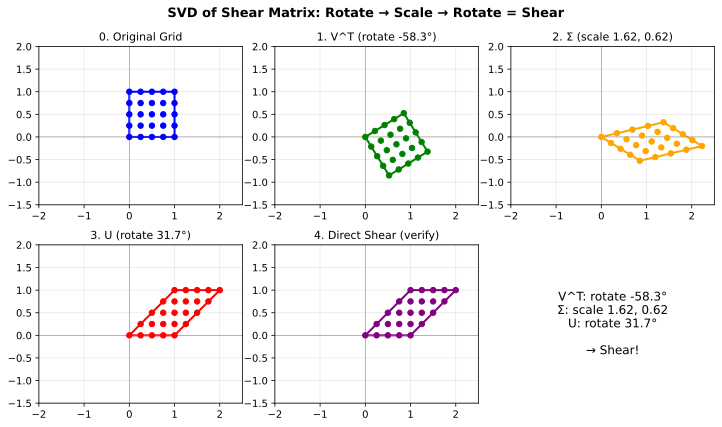

In [33]:
# Visualize SVD decomposition of shear matrix: V^T (rotate) -> Σ (scale) -> U (rotate)
import numpy as np
import matplotlib.pyplot as plt

# Define the shear matrix
shear = np.array([[1, 1], [0, 1]])

# Compute SVD
U, S, Vt = np.linalg.svd(shear)

# Create a unit square grid (vertices of a square + some grid lines)
t = np.linspace(0, 1, 5)
# Create grid points
grid_x, grid_y = np.meshgrid(t, t)
points = np.vstack([grid_x.ravel(), grid_y.ravel()])

# Also create the unit square outline for clarity
square = np.array([[0, 1, 1, 0, 0],
                   [0, 0, 1, 1, 0]])

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()  # Flatten for easier indexing

def plot_grid(ax, pts, sq, title, color):
    ax.scatter(pts[0], pts[1], c=color, s=30, zorder=5)
    ax.plot(sq[0], sq[1], color=color, linestyle='-', linewidth=2)
    ax.set_xlim(-2, 2.5)
    ax.set_ylim(-1.5, 2)
    ax.set_aspect('equal')
    ax.axhline(y=0, color='gray', linewidth=0.5)
    ax.axvline(x=0, color='gray', linewidth=0.5)
    ax.set_title(title, fontsize=11)
    ax.grid(True, alpha=0.3)

# Step 0: Original
plot_grid(axes[0], points, square, "0. Original Grid", 'blue')

# Step 1: Apply V^T (first rotation, about -58.3°)
points_1 = Vt @ points
square_1 = Vt @ square
angle_vt = np.degrees(np.arctan2(Vt[1,0], Vt[0,0]))
plot_grid(axes[1], points_1, square_1, f"1. V^T (rotate {angle_vt:.1f}°)", 'green')

# Step 2: Apply Σ (scaling)
Sigma = np.diag(S)
points_2 = Sigma @ points_1
square_2 = Sigma @ square_1
plot_grid(axes[2], points_2, square_2, f"2. Σ (scale {S[0]:.2f}, {S[1]:.2f})", 'orange')

# Step 3: Apply U (second rotation, about 31.7°)
points_3 = U @ points_2
square_3 = U @ square_2
angle_u = np.degrees(np.arctan2(U[1,0], U[0,0]))
plot_grid(axes[3], points_3, square_3, f"3. U (rotate {angle_u:.1f}°)", 'red')

# Step 4: Direct shear (should match step 3)
points_direct = shear @ points
square_direct = shear @ square
plot_grid(axes[4], points_direct, square_direct, "4. Direct Shear (verify)", 'purple')

# Hide the 6th subplot (unused)
axes[5].axis('off')
axes[5].text(0.5, 0.5, f"V^T: rotate {angle_vt:.1f}°\nΣ: scale {S[0]:.2f}, {S[1]:.2f}\nU: rotate {angle_u:.1f}°\n\n→ Shear!", 
             ha='center', va='center', fontsize=12, transform=axes[5].transAxes)

plt.suptitle("SVD of Shear Matrix: Rotate → Scale → Rotate = Shear", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

After Step 2, the shape only appears sheared because it is drawn in the wrong coordinate frame; true shear appears only after applying a different final rotation.


| Stage    | Coordinate system        | What’s happening                  |
|----------|--------------------------|-----------------------------------|
| Original | standard $(x, y)$        | axes orthogonal                   |
| $V^\top$ | rotated axes             | **coordinate change only**        |
| $\Sigma$ | same rotated axes        | pure scaling                      |
| $U$      | different rotation       | shear appears                     |
| Final    | back in standard plot    | shear visible                     |

For $A = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix},$
the **original coordinate system** is the standard $(x,y)$ axes, and the **new coordinate systems** are the rotated orthonormal bases introduced by $V^\top$ and $U$; **shear appears only because scaling happens in one rotated basis and is observed in another**.

#### 5. Linear Dependence

A set of vectors $\mathbf{v}_1, \ldots, \mathbf{v}_k$ is **linearly dependent** if there exist scalars $a_1, ..., a_k$, not all zero, such that:
$\sum_{i=1}^k a_i \mathbf{v}_i = \mathbf{0}$

Linear dependence means one vector can be written as a combination of others, which causes **dimension compression** in transformations.


#### 6. Rank

The **rank** of a matrix $\mathbf{A}$ is the maximum number of linearly independent columns (or rows). It tells us the dimension of the space that the matrix maps into.

If $\text{rank}(\mathbf{A}) < n$ for an $n\times n$ matrix, the transformation loses information along some directions.

#### 7. Invertibility

An $n\times n$ matrix $\mathbf{A}$ is **invertible** if there exists $\mathbf{A}^{-1}$ such that:
$\mathbf{A}^{-1}\mathbf{A} = \mathbf{I}$

This is possible only when $\mathbf{A}$ has full rank.


In [9]:
# invertible matrix example

M = torch.tensor([[1, 2], [1, 4]], dtype=torch.float32)
M_inv = torch.tensor([[2, -1], [-0.5, 0.5]])
M_inv @ M

tensor([[1., 0.],
        [0., 1.]])

#### 8. Determinant

The **determinant** $\det(\mathbf{A})$ has a geometric interpretation as the **volume scaling factor** of the linear transformation represented by $\mathbf{A}$. 

For a $2\times 2$ matrix:
$$\det\begin{bmatrix} a & b \\ c & d \end{bmatrix} = ad - bc$$

If $\det(\mathbf{A}) = 0$, $\mathbf{A}$ collapses volume into a lower dimension, and is not invertible.


In [10]:
# determinant example

torch.det(torch.tensor([[1, -1], [2, 3]], dtype=torch.float32))

tensor(5.)

#### 9. Tensors and Linear Algebra Operations

Tensors generalize matrices to higher dimensions. Many matrix operations arise as **tensor contractions**, e.g.,

- Dot product: $v_i w_i$
- Vector norm: $\|\mathbf{v}\|_2^2 = v_i v_i$
- Matrix multiplication: $(\mathbf{A}\mathbf{B})_{ik} = \sum_j a_{ij}b_{jk}$

**Einstein summation notation** is used to simplify repeated-index contractions. 

In [11]:
# Define tensors
B = torch.tensor([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
A = torch.tensor([[1, 2], [3, 4]])
v = torch.tensor([1, 2])

# Print out the shapes
A.shape, B.shape, v.shape

(torch.Size([2, 2]), torch.Size([2, 2, 3]), torch.Size([2]))

In [13]:
# using Einstein summation notation to reimplement matrix multiplication

# The notation "ij, j -> i":
# Part	  Meaning
# ij	  Matrix A has 2 dimensions: rows (i) and columns (j)
# j	      Vector v has 1 dimension (j)
# ->	  Produces output with...
# i	      ...only dimension i (the row dimension)

# What happens:
# Matching indices (j): The column index of A aligns with the index of v
# Summation: Index j appears on the left but NOT on the right of ->, so it gets summed over
# Result: A vector with dimension i (number of rows in A)

torch.einsum("ij, j -> i", A, v), A@v

(tensor([ 5, 11]), tensor([ 5, 11]))

In [14]:
# output[k, l] = Σᵢ Σⱼ B[i,j,k] * A[i,l] * v[j]

torch.einsum("ijk, il, j -> kl", B, A, v)

tensor([[ 90, 126],
        [102, 144],
        [114, 162]])

In [15]:
# Correct equivalent:
# Step 1: B[i,j,k] * v[j] summed over j → gives shape (i, k)
# Step 2: Then multiply by A[i,l] and sum over i → gives shape (k, l)

# Method 1: Using tensordot
result1 = torch.tensordot(torch.tensordot(B, v, dims=([1], [0])), A, dims=([0], [0]))

# Method 2: Step by step
Bv = torch.einsum("ijk, j -> ik", B, v)  # (2, 3) - sum over j
result2 = torch.einsum("ik, il -> kl", Bv, A)  # (3, 2) - sum over i

# Method 3: Explicit loops (for understanding)
result3 = torch.zeros(3, 2)
for k in range(3):
    for l in range(2):
        for i in range(2):
            for j in range(2):
                result3[k, l] += B[i, j, k] * A[i, l] * v[j]

result3

tensor([[ 90., 126.],
        [102., 144.],
        [114., 162.]])

=========================== Eigendecompositions =====================

### Eigendecomposition

This section explains the **eigendecomposition of matrices**, including eigenvalues, eigenvectors, and how they relate to matrix transformations and diagonalization — foundational for understanding PCA, spectral methods, and linear dynamical systems.

#### What Are Eigenvalues and Eigenvectors

For a square matrix $\mathbf{A}\in\mathbb{R}^{n\times n}$, if there exists a nonzero vector $\mathbf{v}$ and scalar $\lambda$ such that:

$$
\mathbf{A}\mathbf{v} = \lambda \mathbf{v}
$$

then:

- $\mathbf{v}$ is called an **eigenvector** of $\mathbf{A}$
- $\lambda$ is the corresponding **eigenvalue**

This means **$\mathbf{v}$ is a direction that $\mathbf{A}$ scales by $\lambda$ without changing direction**.

#### Characteristic Equation

To find eigenvalues, solve:

$$
\det(\mathbf{A}-\lambda\mathbf{I}) = 0
$$

This is the **characteristic polynomial** in $\lambda$. Its roots are the eigenvalues of $\mathbf{A}$.

Once $\lambda$ is found, eigenvectors satisfy:

$$
(\mathbf{A}-\lambda\mathbf{I})\mathbf{v}=\mathbf{0}
$$

#### Eigendecomposition

If a matrix $\mathbf{A}$ has $n$ linearly independent eigenvectors, you can form:

- $\mathbf{V}=[\mathbf{v}_1,\ldots,\mathbf{v}_n]$: matrix of eigenvectors
- $\mathbf{\Lambda}=\text{diag}(\lambda_1,\ldots,\lambda_n)$: diagonal matrix of eigenvalues

Then:

$$
\mathbf{A} = \mathbf{V}\mathbf{\Lambda}\mathbf{V}^{-1}
$$

This is the **eigendecomposition** of $\mathbf{A}$. It expresses $\mathbf{A}$ in a basis where it acts like a simple scaling by eigenvalues.

#### Diagonalization and Change of Basis

Eigendecomposition is a **change of basis**:

- Columns of $\mathbf{V}$ form a new basis
- In this basis, $\mathbf{A}$ becomes diagonal with entries $\lambda_i$
- Diagonal matrices are easy to manipulate, e.g., raising $\mathbf{A}$ to a power:

$$
\mathbf{A}^k = \mathbf{V}\mathbf{\Lambda}^k\mathbf{V}^{-1}
$$

This is computationally useful for repeated transformations.

#### Geometric Interpretation

Eigendecomposition shows how a matrix transforms space:

- Each eigenvector $\mathbf{v}_i$ is a direction that $\mathbf{A}$ simply **scales** by $\lambda_i$
- Directions not aligned with eigenvectors get mixed
- Eigenvalues indicate stretching ($|\lambda_i|>1$) or compression ($|\lambda_i|<1$)

#### Connection to Singular Value Decomposition (SVD)

- Eigenvalues/eigenvectors apply to square matrices
- SVD generalizes the concept to any matrix $\mathbf{A}\in\mathbb{R}^{m\times n}$

SVD decomposes $\mathbf{A}$ as:

$$
\mathbf{A} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^\top
$$

and is related to eigen decomposition of $\mathbf{A}^\top\mathbf{A}$.

#### Summary

- An **eigenvector** of $\mathbf{A}$ points in a direction scaled (not rotated) by $\mathbf{A}$
- **Eigenvalues** quantify how much scaling occurs
- **Eigendecomposition** expresses a matrix in terms of its eigenvectors and eigenvalues
- Symmetric matrices have **orthogonal eigenvector bases**, simplifying many algorithms (e.g., PCA) (details see below)

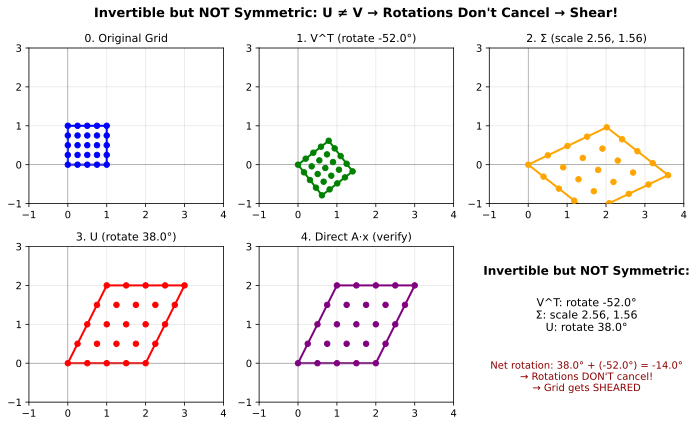

Non-symmetric invertible matrix A:
[[2 1]
 [0 2]]
A^T:
[[2 0]
 [1 2]]
A ≠ A^T? True
det(A) = 4.0 (invertible!)

U:
[[ 0.78820544 -0.61541221]
 [ 0.61541221  0.78820544]]
V:
[[ 0.61541221 -0.78820544]
 [ 0.78820544  0.61541221]]

U ≠ V? True


In [37]:
# Visualization: Invertible but NOT symmetric matrix
# For non-symmetric matrices: U ≠ V in SVD
# This means rotations DON'T cancel → produces shear/skew effect!

import numpy as np
import matplotlib.pyplot as plt

# Define an INVERTIBLE but NOT SYMMETRIC matrix
# det([[2,1],[0,2]]) = 4 ≠ 0, so it's invertible
# But A ≠ A^T, so it's not symmetric
nonsym_inv = np.array([[2, 1], [0, 2]])

# Compute SVD
U_ns, S_ns, Vt_ns = np.linalg.svd(nonsym_inv)

# Create grid
t = np.linspace(0, 1, 5)
grid_x, grid_y = np.meshgrid(t, t)
points = np.vstack([grid_x.ravel(), grid_y.ravel()])
square = np.array([[0, 1, 1, 0, 0], [0, 0, 1, 1, 0]])

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

def plot_grid(ax, pts, sq, title, color):
    ax.scatter(pts[0], pts[1], c=color, s=30, zorder=5)
    ax.plot(sq[0], sq[1], color=color, linestyle='-', linewidth=2)
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 3)
    ax.set_aspect('equal')
    ax.axhline(y=0, color='gray', linewidth=0.5)
    ax.axvline(x=0, color='gray', linewidth=0.5)
    ax.set_title(title, fontsize=11)
    ax.grid(True, alpha=0.3)

# Step 0: Original
plot_grid(axes[0], points, square, "0. Original Grid", 'blue')

# Step 1: Apply V^T
points_1 = Vt_ns @ points
square_1 = Vt_ns @ square
angle_vt_ns = np.degrees(np.arctan2(Vt_ns[1,0], Vt_ns[0,0]))
plot_grid(axes[1], points_1, square_1, f"1. V^T (rotate {angle_vt_ns:.1f}°)", 'green')

# Step 2: Apply Σ
Sigma_ns = np.diag(S_ns)
points_2 = Sigma_ns @ points_1
square_2 = Sigma_ns @ square_1
plot_grid(axes[2], points_2, square_2, f"2. Σ (scale {S_ns[0]:.2f}, {S_ns[1]:.2f})", 'orange')

# Step 3: Apply U
points_3 = U_ns @ points_2
square_3 = U_ns @ square_2
angle_u_ns = np.degrees(np.arctan2(U_ns[1,0], U_ns[0,0]))
plot_grid(axes[3], points_3, square_3, f"3. U (rotate {angle_u_ns:.1f}°)", 'red')

# Step 4: Direct transformation
points_direct = nonsym_inv @ points
square_direct = nonsym_inv @ square
plot_grid(axes[4], points_direct, square_direct, "4. Direct A·x (verify)", 'purple')

# Summary
axes[5].axis('off')
axes[5].text(0.5, 0.8, "Invertible but NOT Symmetric:", ha='center', va='center', fontsize=12, fontweight='bold', transform=axes[5].transAxes)
axes[5].text(0.5, 0.55, f"V^T: rotate {angle_vt_ns:.1f}°\nΣ: scale {S_ns[0]:.2f}, {S_ns[1]:.2f}\nU: rotate {angle_u_ns:.1f}°", 
             ha='center', va='center', fontsize=11, transform=axes[5].transAxes)
net_rotation = angle_u_ns + angle_vt_ns
axes[5].text(0.5, 0.2, f"Net rotation: {angle_u_ns:.1f}° + ({angle_vt_ns:.1f}°) = {net_rotation:.1f}°\n→ Rotations DON'T cancel!\n→ Grid gets SHEARED", 
             ha='center', va='center', fontsize=10, color='darkred', transform=axes[5].transAxes)

plt.suptitle("Invertible but NOT Symmetric: U ≠ V → Rotations Don't Cancel → Shear!", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Non-symmetric invertible matrix A:\n{nonsym_inv}")
print(f"A^T:\n{nonsym_inv.T}")
print(f"A ≠ A^T? {not np.allclose(nonsym_inv, nonsym_inv.T)}")
print(f"det(A) = {np.linalg.det(nonsym_inv):.1f} (invertible!)")
print(f"\nU:\n{U_ns}")
print(f"V:\n{Vt_ns.T}")
print(f"\nU ≠ V? {not np.allclose(U_ns, Vt_ns.T)}")

#### Symmetric Matrix: Orthogonal Diagonalization

##### Theorem (Spectral Theorem)

If a real matrix
$$
A \in \mathbb{R}^{n \times n}
\quad \text{and} \quad
A = A^\top,
$$
then $A$ can always be **orthogonally diagonalized**:

$$
A = Q \Lambda Q^\top
$$

where:

- $Q \in \mathbb{R}^{n \times n}$ is an **orthogonal matrix**
  - columns of $Q$ are **orthonormal eigenvectors** of $A$
  - $Q^\top Q = QQ^\top = I$
- $\Lambda \in \mathbb{R}^{n \times n}$ is a **diagonal matrix**
  - diagonal entries are the **real eigenvalues** of $A$

This result is guaranteed by the **spectral theorem**.

##### Meaning of “Orthogonal” Diagonalization

- The eigenvectors of a symmetric matrix can be chosen to be:
  - mutually perpendicular
  - unit length
- Changing coordinates to this eigenvector basis removes all interactions between dimensions.

In this basis, the matrix acts as:
$\mathbf{y} = \Lambda \mathbf{x}$
i.e., each coordinate is scaled independently.

##### Why Symmetry Matters

Symmetry ensures:

1. All eigenvalues of $A$ are **real**
2. Eigenvectors span the entire space
3. Eigenvectors associated with distinct eigenvalues are **orthogonal**

Without symmetry, a matrix may fail to be diagonalizable.

##### Geometric Interpretation

A symmetric matrix represents a linear transformation that:
- stretches or compresses space,
- may reflect across certain axes,
- but does **not** rotate or shear.

Each eigenvector defines an axis along which scaling occurs by its eigenvalue.

##### Computational Benefits

Because $Q^\top = Q^{-1}$:

- **Matrix inverse** (if all eigenvalues are nonzero):
$
A^{-1} = Q \Lambda^{-1} Q^\top
$

- **Matrix powers**:
$
A^k = Q \Lambda^k Q^\top
$

- **Quadratic forms**:
$
\mathbf{x}^\top A \mathbf{x}
= \sum_i \lambda_i (\mathbf{q}_i^\top \mathbf{x})^2
$

These properties make symmetric matrices especially important in machine learning.

##### Special Cases

- **Positive definite**:
  $
  \lambda_i > 0
  \quad \Rightarrow \quad \text{pure stretching}
  $

- **Positive semidefinite**:
  $
  \lambda_i \ge 0
  \quad \Rightarrow \quad \text{stretching or flattening}
  $

- **Indefinite**:
  eigenvalues of mixed signs → saddle-shaped geometry

##### Common Machine Learning Examples

- Covariance matrices
- Hessians of scalar loss functions
- Graph Laplacians
- Kernel (Gram) matrices

All rely on orthogonal diagonalization.

##### One-Line Summary

> Any real symmetric matrix admits an orthogonal eigendecomposition with real eigenvalues and orthonormal eigenvectors.

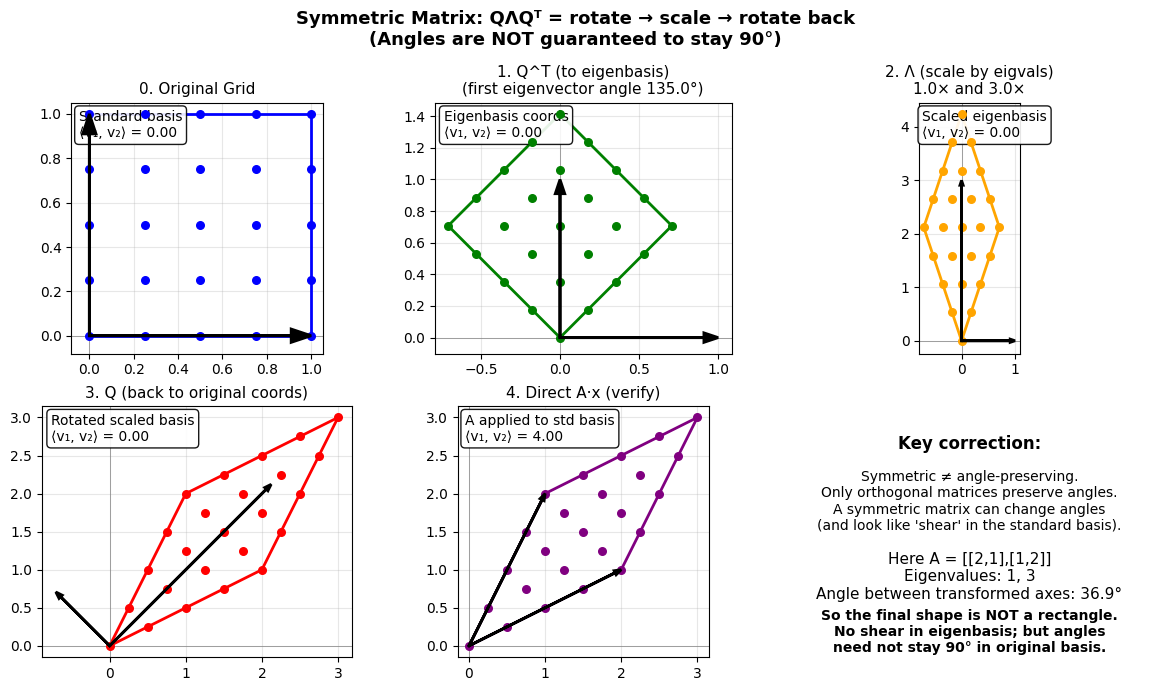

A =
[[2. 1.]
 [1. 2.]]
Eigenvalues: [1. 3.]
Eigenvectors (columns of Q):
[[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]

Angle between images of e1 and e2 under A: 36.87°
A symmetric matrix preserves perpendicularity only in its eigenbasis, not in the original coordinate system
Note: angles are preserved only by orthogonal transformations (Q or rotations), not by general symmetric matrices.


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Symmetric (but not orthogonal) matrix
A = np.array([[2., 1.],
              [1., 2.]])

# Eigendecomposition for symmetric matrices: A = Q Λ Q^T
eigvals, Q = np.linalg.eigh(A)      # columns of Q are orthonormal eigenvectors
Lambda = np.diag(eigvals)
Qt = Q.T

# Create grid + unit square
t = np.linspace(0, 1, 5)
grid_x, grid_y = np.meshgrid(t, t)
points = np.vstack([grid_x.ravel(), grid_y.ravel()])
square = np.array([[0, 1, 1, 0, 0],
                   [0, 0, 1, 1, 0]])

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.flatten()

def plot_grid(ax, pts, sq, title, color):
    ax.scatter(pts[0], pts[1], c=color, s=30, zorder=5)
    ax.plot(sq[0], sq[1], color=color, linewidth=2)
    ax.set_aspect('equal', adjustable='box')
    ax.axhline(0, color='gray', linewidth=0.5)
    ax.axvline(0, color='gray', linewidth=0.5)
    ax.grid(True, alpha=0.3)
    ax.set_title(title, fontsize=11)

def draw_vectors_with_dot(ax, v1, v2, label, color='black'):
    """
    Draw two vectors from the origin and annotate their dot product.
    """
    # Draw vectors
    ax.arrow(0, 0, v1[0], v1[1],
             head_width=0.06, length_includes_head=True,
             linewidth=2, color=color, zorder=10)
    ax.arrow(0, 0, v2[0], v2[1],
             head_width=0.06, length_includes_head=True,
             linewidth=2, color=color, zorder=10)

    # Compute dot product
    dot = np.dot(v1, v2)

    # Annotate
    ax.text(
        0.03, 0.97,
        f"{label}\n⟨v₁, v₂⟩ = {dot:.2f}",
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=10,
        bbox=dict(boxstyle="round", fc="white", alpha=0.9)
    )

# Step 0: Original
plot_grid(axes[0], points, square, "0. Original Grid", 'blue')

draw_vectors_with_dot(
    axes[0],
    np.array([1, 0]),
    np.array([0, 1]),
    "Standard basis"
)

# Step 1: Rotate into eigenvector coordinates (Q^T)
points_1 = Qt @ points
square_1 = Qt @ square
angle_q = np.degrees(np.arctan2(Q[1,0], Q[0,0]))
plot_grid(axes[1], points_1, square_1,
          f"1. Q^T (to eigenbasis)\n(first eigenvector angle {angle_q:.1f}°)",
          'green')
draw_vectors_with_dot(
    axes[1],
    np.array([1, 0]),
    np.array([0, 1]),
    "Eigenbasis coords"
)

# Step 2: Scale along eigenvector axes (Λ)
points_2 = Lambda @ points_1
square_2 = Lambda @ square_1
plot_grid(axes[2], points_2, square_2,
          f"2. Λ (scale by eigvals)\n{eigvals[0]:.1f}× and {eigvals[1]:.1f}×",
          'orange')

draw_vectors_with_dot(
    axes[2],
    np.array([eigvals[0], 0]),
    np.array([0, eigvals[1]]),
    "Scaled eigenbasis"
)

# Step 3: Rotate back (Q)
points_3 = Q @ points_2
square_3 = Q @ square_2
plot_grid(axes[3], points_3, square_3, "3. Q (back to original coords)", 'red')

draw_vectors_with_dot(
    axes[3],
    Q[:, 0] * eigvals[0],
    Q[:, 1] * eigvals[1],
    "Rotated scaled basis"
)

# Step 4: Direct transformation (verify)
points_direct = A @ points
square_direct = A @ square
plot_grid(axes[4], points_direct, square_direct, "4. Direct A·x (verify)", 'purple')

draw_vectors_with_dot(
    axes[4],
    A @ np.array([1, 0]),
    A @ np.array([0, 1]),
    "A applied to std basis"
)

# Compute angle between transformed edges (images of e1 and e2)
v1 = square_direct[:, 1] - square_direct[:, 0]  # A*(1,0)
v2 = square_direct[:, 3] - square_direct[:, 0]  # A*(0,1)
cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
angle_deg = np.degrees(np.arccos(np.clip(cos_angle, -1, 1)))

# Summary panel
axes[5].axis('off')
axes[5].text(0.5, 0.85, "Key correction:", ha='center', va='center',
             fontsize=12, fontweight='bold', transform=axes[5].transAxes)
axes[5].text(0.5, 0.62,
             "Symmetric ≠ angle-preserving.\nOnly orthogonal matrices preserve angles.\nA symmetric matrix can change angles\n(and look like 'shear' in the standard basis).",
             ha='center', va='center', fontsize=10, transform=axes[5].transAxes)
axes[5].text(0.5, 0.32,
             f"Here A = [[2,1],[1,2]]\nEigenvalues: {eigvals[0]:.0f}, {eigvals[1]:.0f}\nAngle between transformed axes: {angle_deg:.1f}°",
             ha='center', va='center', fontsize=11, transform=axes[5].transAxes)
axes[5].text(0.5, 0.10,
             "So the final shape is NOT a rectangle.\nNo shear in eigenbasis; but angles\nneed not stay 90° in original basis.",
             ha='center', va='center', fontsize=10, transform=axes[5].transAxes,
             fontweight='bold')

plt.suptitle("Symmetric Matrix: QΛQᵀ = rotate → scale → rotate back\n(Angles are NOT guaranteed to stay 90°)",
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"A =\n{A}")
print(f"Eigenvalues: {eigvals}")
print(f"Eigenvectors (columns of Q):\n{Q}")
print(f"\nAngle between images of e1 and e2 under A: {angle_deg:.2f}°")
print(f"A symmetric matrix preserves perpendicularity only in its eigenbasis, not in the original coordinate system")
print(f"Note: angles are preserved only by orthogonal transformations (Q or rotations), not by general symmetric matrices.")

In [16]:
%matplotlib inline
import torch
from IPython import display
from d2l import torch as d2l

torch.linalg.eig(torch.tensor([[2, 1], [2, 3]], dtype=torch.float64))

torch.return_types.linalg_eig(
eigenvalues=tensor([1.+0.j, 4.+0.j], dtype=torch.complex128),
eigenvectors=tensor([[-0.7071+0.j, -0.4472+0.j],
        [ 0.7071+0.j, -0.8944+0.j]], dtype=torch.complex128))

#### Gershgorin Circle Theorem

The **Gershgorin Circle Theorem** provides simple and effective **bounds on the locations of eigenvalues** of a square matrix using only its entries.

##### Theorem Statement

Let $A = [a_{ij}] \in \mathbb{C}^{n \times n}$.  
For each row $i$, define the **Gershgorin disc**:

$$
D_i = \left\{ z \in \mathbb{C} \;\middle|\; |z - a_{ii}| \le \sum_{j \ne i} |a_{ij}| \right\}
$$

Then **every eigenvalue of $A$** lies in **at least one** of these discs:

$$
\text{Spec}(A) \subseteq \bigcup_{i=1}^n D_i
$$

##### Interpretation

- Each disc is centered at the diagonal entry $a_{ii}$.
- The radius is the sum of the magnitudes of the off-diagonal entries in that row.
- Eigenvalues must lie **near the diagonal**, unless off-diagonal terms are large.

##### Column Version

There is an equivalent formulation using columns:

$$
|z - a_{ii}| \le \sum_{j \ne i} |a_{ji}|
$$

You may use either row-based or column-based discs.

##### Key Consequences

1. **Eigenvalue localization**  
   Quickly estimates where eigenvalues are without computing them.

2. **Diagonal dominance ⇒ stability**  
   If
   $$
   |a_{ii}| > \sum_{j \ne i} |a_{ij}| \quad \forall i
   $$
   then:
   - All eigenvalues are nonzero
   - The matrix is invertible

3. **Separated discs imply eigenvalue count**  
   If a group of $k$ discs is disjoint from the others, then exactly $k$ eigenvalues lie inside that group.

##### Symmetric / Real Case

If $A$ is real and symmetric:
- Eigenvalues are real
- Gershgorin discs reduce to **intervals on the real line**

This gives easy bounds on minimum and maximum eigenvalues.

##### Intuition

- Diagonal entries pull eigenvalues toward themselves.
- Off-diagonal entries "spread" eigenvalues outward.
- Strong diagonal dominance ⇒ eigenvalues close to diagonal.

##### Why This Matters (ML & Numerical Linear Algebra)

- Estimating eigenvalue ranges (e.g., Hessians, covariance matrices)
- Checking invertibility and conditioning
- Stability analysis of iterative methods
- Preconditioning and convergence guarantees

##### One-Line Summary

> Every eigenvalue of a matrix lies within at least one Gershgorin disc centered at a diagonal entry, with radius given by the sum of the off-diagonal magnitudes.

#### Example:

We consider the matrix

$$
A =
\begin{bmatrix}
1.0 & 0.1 & 0.1 & 0.1 \\
0.1 & 3.0 & 0.2 & 0.3 \\
0.1 & 0.2 & 5.0 & 0.5 \\
0.1 & 0.3 & 0.5 & 9.0
\end{bmatrix}.
$$

We compute the Gershgorin radii:

$$
r_1 = 0.3,\quad r_2 = 0.6,\quad r_3 = 0.8,\quad r_4 = 0.9.
$$

Since the matrix is **symmetric**, all eigenvalues are **real**. Therefore, all eigenvalues must lie within one of the following intervals:

$$
[a_{11} - r_1,\; a_{11} + r_1]
= [0.7,\; 1.3],
$$

$$
[a_{22} - r_2,\; a_{22} + r_2]
= [2.4,\; 3.6],
$$

$$
[a_{33} - r_3,\; a_{33} + r_3]
= [4.2,\; 5.8],
$$

$$
[a_{44} - r_4,\; a_{44} + r_4]
= [8.1,\; 9.9].
$$

In [17]:
A = torch.tensor([[1.0, 0.1, 0.1, 0.1],
              [0.1, 3.0, 0.2, 0.3],
              [0.1, 0.2, 5.0, 0.5],
              [0.1, 0.3, 0.5, 9.0]])

v, _ = torch.linalg.eig(A)
v

tensor([9.0803+0.j, 0.9923+0.j, 4.9539+0.j, 2.9734+0.j])

#### A Useful Application: The Growth of Iterated Maps

Now we explore a powerful application of eigenvalue theory that has deep connections to neural network training.

##### The Problem: Repeated Matrix Application

Consider a simplified neural network where we ignore non-linearities. The forward pass through $N$ layers becomes:

$$\mathbf{v}_{out} = \mathbf{A}^N \mathbf{v}_{in}$$

What happens to the vector as we apply $\mathbf{A}$ repeatedly?

- **If vectors grow**: Small input changes get amplified into huge output changes → model becomes unstable
- **If vectors shrink**: After many layers, output becomes nearly independent of input → model can't learn

##### Why Eigenvalues Matter

The key insight: **long-term behavior is dominated by the largest eigenvalue**.

When we repeatedly apply $\mathbf{A}$:
1. A random vector has components in all eigenvector directions
2. Each application stretches by the corresponding eigenvalue
3. After many iterations, the **principal eigenvector** (largest eigenvalue) dominates
4. The stretching factor converges to **the largest eigenvalue's magnitude**

##### The Spectral Radius

The **spectral radius** $\rho(\mathbf{A})$ is the maximum magnitude among all eigenvalues:

$$\rho(\mathbf{A}) = \max_i |\lambda_i|$$

Its behavior determines stability:
- $\rho(\mathbf{A}) > 1$: Vectors **explode** exponentially
- $\rho(\mathbf{A}) < 1$: Vectors **vanish** exponentially  
- $\rho(\mathbf{A}) = 1$: Vectors remain **stable**

#### Experiment: Observing Explosive Growth

Let's create a random matrix and see what happens when we repeatedly apply it to a vector. We'll track the norm of the vector after each iteration.

In [18]:
torch.manual_seed(42)

k = 5
A = torch.randn(k, k, dtype=torch.float64)
A

tensor([[ 0.2996,  0.2424,  0.2832, -0.2329,  0.6712],
        [ 0.7818, -1.7903, -1.7484,  0.1735, -0.1182],
        [-1.7446, -0.4695,  0.4573,  0.5177, -0.2771],
        [-0.6641,  0.6551,  0.2616, -1.5265, -0.3311],
        [-0.6378,  0.1072,  0.7096,  0.3009, -0.2869]], dtype=torch.float64)

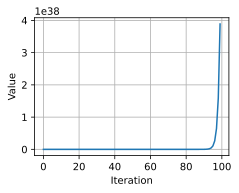

In [19]:
# Calculate the sequence of norms after repeatedly applying `A`
v_in = torch.randn(k, 1, dtype=torch.float64)

norm_list = [torch.norm(v_in).item()]
for i in range(1, 100):
    v_in = A @ v_in
    norm_list.append(torch.norm(v_in).item())

# The norm is growing uncontrollably!
d2l.plot(torch.arange(0, 100), norm_list, 'Iteration', 'Value')

The norm grows uncontrollably! This is **exponential growth** — exactly what happens with exploding gradients in deep networks.

#### Finding the Stretching Factor

Let's compute the ratio $\frac{\|\mathbf{A}^k\mathbf{v}\|}{\|\mathbf{A}^{k-1}\mathbf{v}\|}$ at each step. Theory predicts this should converge to the **largest eigenvalue magnitude**.

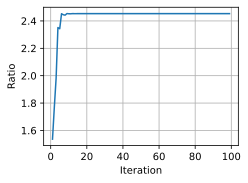

In [20]:
# Compute the scaling factor of the norms
norm_ratio_list = []
for i in range(1, 100):
    norm_ratio_list.append(norm_list[i]/norm_list[i - 1])

d2l.plot(torch.arange(1, 100), norm_ratio_list, 'Iteration', 'Ratio')

The ratio converges to approximately **2.45** — this is the spectral radius of our matrix! The small fluctuations at the end are due to floating-point precision.

#### Verifying with Actual Eigenvalues

Let's compute the actual eigenvalues and confirm our observation.

In [21]:
# Compute the eigenvalues
eigs = torch.linalg.eig(A).eigenvalues.tolist()
norm_eigs = [torch.abs(torch.tensor(x)) for x in eigs]
norm_eigs.sort()
print(f'norms of eigenvalues: {norm_eigs}')

norms of eigenvalues: [tensor(0.3490), tensor(1.1296), tensor(1.1296), tensor(1.1828), tensor(2.4532)]


The largest eigenvalue magnitude matches our observed stretching factor! This confirms the theory.

#### The Fix: Rescaling by Spectral Radius

To stabilize the iteration, we **divide the matrix by its spectral radius**:

$$\mathbf{A}_{normalized} = \frac{\mathbf{A}}{\rho(\mathbf{A})}$$

This ensures the new largest eigenvalue has magnitude 1, so vectors neither explode nor vanish.

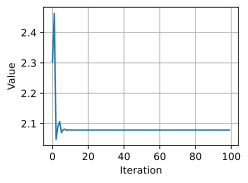

In [22]:
# Rescale the matrix `A`
A /= norm_eigs[-1]

# Do the same experiment again
v_in = torch.randn(k, 1, dtype=torch.float64)

norm_list = [torch.norm(v_in).item()]
for i in range(1, 100):
    v_in = A @ v_in
    norm_list.append(torch.norm(v_in).item())

d2l.plot(torch.arange(0, 100), norm_list, 'Iteration', 'Value')

Now the norms stabilize instead of exploding! The vector reaches an equilibrium.

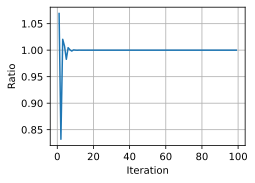

In [23]:
# Also plot the ratio
norm_ratio_list = []
for i in range(1, 100):
    norm_ratio_list.append(norm_list[i]/norm_list[i-1])

d2l.plot(torch.arange(1, 100), norm_ratio_list, 'Iteration', 'Ratio')

The ratio now oscillates around 1.0 instead of being consistently above 1. The oscillations occur because there are other eigenvalues with magnitude close to 1 that compete with the principal eigenvalue.

#### Connection to Deep Learning: Vanishing & Exploding Gradients

This theory directly explains the **vanishing and exploding gradient problem** in neural networks:

**In RNNs**, gradients involve products of weight matrices across time:
$$\frac{\partial \mathbf{h}_t}{\partial \mathbf{h}_0} \propto \mathbf{W}_{hh}^t$$

The spectral radius of $\mathbf{W}_{hh}$ determines:
- $\rho(\mathbf{W}_{hh}) > 1$: Gradients **explode** → training fails
- $\rho(\mathbf{W}_{hh}) < 1$: Gradients **vanish** → no learning for early time steps

**Practical Solutions in Deep Learning:**
1. **Proper weight initialization** (Xavier/He) aims to keep spectral radius ≈ 1
2. **Gradient clipping** prevents explosion by capping gradient norms
3. **Architectures like LSTM/GRU** use gating to control information flow

> **Key Takeaway**: The abstract concept of eigenvalues has very concrete implications — the spectral radius controls whether your network can learn or suffers from numerical instability.

====================== Single Variable Calculus ======================

### Single-Variable Calculus

This section reviews the core ideas of calculus in one variable that are commonly used in machine learning, including derivatives, rules of differentiation, and interpretations of gradients.

#### Derivatives: Instantaneous Rate of Change

For a function $f(x)$, the **derivative** at a point $x$ measures the instantaneous rate of change of $f$ with respect to $x$. Formally:

$$
f'(x) = \lim_{\Delta x \to 0} \frac{f(x+\Delta x) - f(x)}{\Delta x}.
$$

This captures how $f(x)$ changes for a very small change in $x$.

#### Common Derivatives

Some basic derivative rules:

- Power rule:
  $$
  \frac{d}{dx} x^n = n x^{n-1}
  $$

- Exponential:
  $$
  \frac{d}{dx} e^x = e^x
  $$

- Logarithmic:
  $$
  \frac{d}{dx} \ln x = \frac{1}{x}
  $$

- Constant multiple:
  $$
  \frac{d}{dx} [c f(x)] = c f'(x)
  $$

#### Sum and Constant Rules

- Sum rule:
  $$
  \frac{d}{dx} [f(x) + g(x)] = f'(x) + g'(x)
  $$

- Constant rule:
  $$
  \frac{d}{dx} c = 0
  $$

#### Product and Quotient Rules

For two functions $u(x)$ and $v(x)$:

- Product rule:
  $$
  \frac{d}{dx} [u(x)v(x)]
  = u'(x)v(x) + u(x)v'(x)
  $$

- Quotient rule:
  $$
  \frac{d}{dx}\left[\frac{u(x)}{v(x)}\right]
  = \frac{u'(x)v(x) - u(x)v'(x)}{[v(x)]^2}
  $$

#### Chain Rule

For composite functions $f(g(x))$:

$$
\frac{d}{dx} f(g(x))
= f'(g(x)) \cdot g'(x).
$$

This allows us to differentiate nested functions.

#### Higher-Order Derivatives

The **second derivative** measures the rate of change of the first derivative:

$$
f''(x) = \frac{d}{dx}[f'(x)].
$$

It captures the curvature or concavity of $f$.

#### Interpretation of Derivatives

- The sign of $f'(x)$ tells whether $f$ is increasing or decreasing.
- $f'(x)=0$ is a **critical point** — a candidate for a local extremum.
- The second derivative $f''(x)$ indicates concavity:
  - $f''(x)>0$: concave up (valley)
  - $f''(x)<0$: concave down (hill)

#### Taylor Series (Local Approximation)

A smooth function can be approximated near $a$:

$$
f(x)
\approx f(a)
+ f'(a)(x-a)
+ \frac{f''(a)}{2!}(x-a)^2
+ \cdots
$$

The first few terms give a local linear or quadratic approximation.

#### Mean Value Theorem

For a continuous function on $[a,b]$ that is differentiable on $(a,b)$:

There exists $c\in(a,b)$ such that

$$
f'(c) = \frac{f(b)-f(a)}{b-a}.
$$

This formalizes the idea that the instantaneous slope equals the average slope somewhere in the interval.

#### Optimization and Critical Points

To find minima or maxima:

1. Set derivative to zero: $f'(x)=0$
2. Use the second derivative:
   - $f''(x)>0$: local minimum
   - $f''(x)<0$: local maximum

For convex functions, any critical point is a global minimum.

#### Summary

- Derivatives measure local rates of change.
- Rules for derivatives (power, sum, chain, product, quotient) simplify computation.
- Second derivatives capture curvature.
- Taylor series provide local approximations.
- The mean value theorem connects average and instantaneous change.
- Optimization uses derivatives to locate extrema.

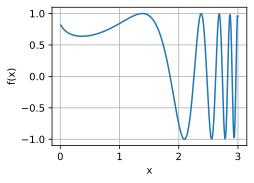

In [1]:
%matplotlib inline
import torch
from IPython import display
from d2l import torch as d2l

torch.pi = torch.acos(torch.zeros(1)).item() * 2  # Define pi in torch

# Plot a function in a normal range
x_big = torch.arange(0.01, 3.01, 0.01)
ys = torch.sin(x_big**x_big)
d2l.plot(x_big, ys, 'x', 'f(x)')

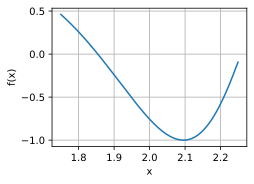

In [2]:
# Plot a the same function in a tiny range
x_med = torch.arange(1.75, 2.25, 0.001)
ys = torch.sin(x_med**x_med)
d2l.plot(x_med, ys, 'x', 'f(x)')

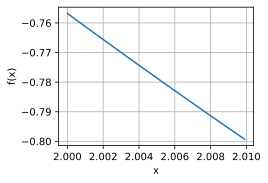

In [6]:
# Plot a the same function in a tiny range
x_small = torch.arange(2.0, 2.01, 0.0001)
ys = torch.sin(x_small**x_small)
d2l.plot(x_small, ys, 'x', 'f(x)')

In [7]:
# Define our function
def L(x):
    return x**2 + 1701*(x-4)**3

# Print the difference divided by epsilon for several epsilon, at point 4
for epsilon in [0.1, 0.001, 0.0001, 0.00001]:
    print(f'epsilon = {epsilon:.5f} -> {(L(4+epsilon) - L(4)) / epsilon:.5f}')

epsilon = 0.10000 -> 25.11000
epsilon = 0.00100 -> 8.00270
epsilon = 0.00010 -> 8.00012
epsilon = 0.00001 -> 8.00001


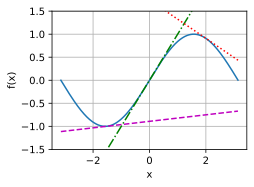

In [8]:
# Compute sin
xs = torch.arange(-torch.pi, torch.pi, 0.01)
plots = [torch.sin(xs)]

# Compute some linear approximations. Use d(sin(x))/dx = cos(x)
for x0 in [-1.5, 0.0, 2.0]:
    plots.append(torch.sin(torch.tensor(x0)) + (xs - x0) *
                 torch.cos(torch.tensor(x0)))

d2l.plot(xs, plots, 'x', 'f(x)', ylim=[-1.5, 1.5])

Take $f(x) = e^x$ as an example. Since $e^x$ is its own derivative, we know that $f^{(n)}(x) = e^x$. Therefore, $e^x$ can be reconstructed by taking the Taylor series at $x_0 = 0$, i.e.,

$$
e^x = \sum_{n=0}^{\infty} \frac{x^n}{n!} = 1 + x + \frac{x^2}{2} + \frac{x^3}{6} + \cdots
$$

#### Effective Range (Radius of Convergence)

**For $e^x$: The series converges for all $x \in \mathbb{R}$** — its radius of convergence is **infinite**.

##### How We Determine the Range

The radius of convergence $R$ is found using the **ratio test**. For a series $\sum a_n x^n$:

$$
R = \lim_{n \to \infty} \left| \frac{a_n}{a_{n+1}} \right|
$$

For $e^x$, where $a_n = \frac{1}{n!}$:

$$
R = \lim_{n \to \infty} \left| \frac{1/n!}{1/(n+1)!} \right| = \lim_{n \to \infty} (n+1) = \infty
$$

**Why does this happen?** The factorial $n!$ grows **much faster** than any power $x^n$. No matter how large $|x|$ is, eventually the $n!$ in the denominator dominates, making the terms shrink to zero rapidly.

##### Intuition: Factorial Beats Exponential

Consider $x = 100$. The terms $\frac{100^n}{n!}$ eventually shrink because:
- $\frac{100^{10}}{10!} \approx 2.76 \times 10^{13}$ (still large)
- $\frac{100^{100}}{100!} \approx 10^{42}$ (but...)
- $\frac{100^{200}}{200!} \approx 10^{-74}$ (vanishingly small!)

The factorial's super-exponential growth guarantees convergence everywhere.

##### Contrast with Other Series

| Function | Series | Radius $R$ | Why Limited? |
|----------|--------|------------|--------------|
| $e^x$ | $\sum \frac{x^n}{n!}$ | $\infty$ | Factorial dominates |
| $\sin x$ | $\sum \frac{(-1)^n x^{2n+1}}{(2n+1)!}$ | $\infty$ | Factorial dominates |
| $\frac{1}{1-x}$ | $\sum x^n$ | $1$ | No factorial — geometric series |
| $\ln(1+x)$ | $\sum \frac{(-1)^{n+1}x^n}{n}$ | $1$ | Only $1/n$ decay, not enough |

##### The Catch: Finite Truncation

While the **infinite** series converges everywhere, a **truncated** Taylor polynomial is only accurate near $x_0 = 0$. As you move away from $x_0 = 0$:

- **Low degree**: Good only very close to 0
- **Higher degree**: Good over a wider range
- **Infinite terms**: Exact everywhere

In the plot below:
- Degree 1 diverges quickly from $e^x$
- Degree 5 stays close up to about $x = 2$
- With enough terms, you could approximate $e^x$ accurately even at $x = 100$

> **Summary**: "Local approximation" refers to **truncated** Taylor series. The **full infinite series** for $e^x$ converges globally — but you need more terms as you move farther from the expansion point.

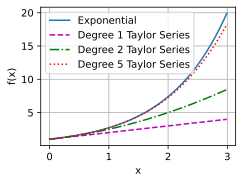

In [24]:
# Compute the exponential function
xs = torch.arange(0, 3, 0.01)
ys = torch.exp(xs)

# Compute a few Taylor series approximations
P1 = 1 + xs
P2 = 1 + xs + xs**2 / 2
P5 = 1 + xs + xs**2 / 2 + xs**3 / 6 + xs**4 / 24 + xs**5 / 120

d2l.plot(xs, [ys, P1, P2, P5], 'x', 'f(x)', legend=[
    "Exponential", "Degree 1 Taylor Series", "Degree 2 Taylor Series",
    "Degree 5 Taylor Series"])

======================== Multivariable Calculus =======================

### Multivariable Calculus

This section reviews core ideas from calculus in multiple variables that are frequently used in machine learning, including partial derivatives, gradients, directional derivatives, optimization, and chain rules.

#### Partial Derivatives

For a function 
$$f(x_1, x_2, \ldots, x_n),$$
the **partial derivative** with respect to $x_i$ measures how $f$ changes when only $x_i$ changes (others fixed):

$$
\frac{\partial f}{\partial x_i}(x)
= \lim_{\Delta x_i \to 0}
\frac{f(x_1, \ldots, x_i+\Delta x_i, \ldots, x_n)
- f(x_1, \ldots, x_i, \ldots, x_n)}{\Delta x_i}.
$$

#### Gradient Vector

The **gradient** of $f$ is the vector of all partial derivatives:

$$
\nabla f = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\frac{\partial f}{\partial x_2} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}.
$$

- It points in the direction of **steepest increase** of $f$.
- Its magnitude gives the rate of maximum increase.
- Gradient is central to optimization methods like gradient descent.

#### Directional Derivative

The **directional derivative** of $f$ at $x$ in direction $u$ is:

$$
D_{\mathbf{u}} f(x)
= \nabla f(x)^\top \mathbf{u}.
$$

It measures the rate of change of $f$ in an arbitrary direction $\mathbf{u}$.

#### Chain Rule (Multivariable)

If $f$ depends on intermediate variables that depend on $x$, the chain rule expresses total derivatives in terms of partial derivatives.

Example: if $z = f(x,y)$ and $x = g(t), y = h(t)$:

$$
\frac{dz}{dt}
= \frac{\partial f}{\partial x}\frac{dx}{dt}
+ \frac{\partial f}{\partial y}\frac{dy}{dt}.
$$

This generalizes to functions of many variables and vector inputs.

#### Jacobian Matrix

For a vector-valued function $f: \mathbb{R}^n \to \mathbb{R}^m$,

$$
f(x) = \begin{bmatrix}
f_1(x)\\
f_2(x)\\
\vdots\\
f_m(x)
\end{bmatrix},
$$

the **Jacobian** is the matrix of first partials:

$$
J_f(x)
= \begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \cdots & \frac{\partial f_1}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial f_m}{\partial x_1} & \cdots & \frac{\partial f_m}{\partial x_n}
\end{bmatrix}.
$$

Each row is the gradient of one component function.  
- The Jacobian generalizes the derivative to vector outputs.

#### Hessian Matrix

For a scalar function $f: \mathbb{R}^n \to \mathbb{R}$, the **Hessian** is the matrix of second-order partial derivatives:

$$
H_f(x)
= \begin{bmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_n}\\
\vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial x_n \partial x_1} & \cdots &
\frac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}.
$$

- Hessian is symmetric if second partials are continuous.
- It characterizes local curvature and appears in Newton’s method and second-order optimization.

#### Gradient Descent in Multiple Dimensions

Gradient descent updates parameters $\mathbf{w}$ using the gradient:

$$
\mathbf{w}_{t+1}
= \mathbf{w}_t - \alpha \nabla f(\mathbf{w}_t),
$$

where $\alpha$ is the learning rate.

- This extends the single-variable idea to vector spaces.
- Convergence behavior depends on the shape of $f$ (curvature, convexity, step size).

#### Stationary Points and Critical Points

- A point $x^*$ is **stationary** if $\nabla f(x^*) = 0$.
- Stationary points include local minima, local maxima, and saddle points.
- Second-order information (Hessian) helps distinguish types:
  - If $H_f(x^*)$ is positive definite $\Rightarrow$ local minimum.
  - If negative definite $\Rightarrow$ local maximum.
  - Otherwise $\Rightarrow$ saddle point.

#### Multivariable Taylor Expansion

Around a point $a$:

$$
f(x)
\approx f(a)
+ \nabla f(a)^\top (x - a)
+ \tfrac{1}{2}(x - a)^\top H_f(a) (x - a)
+ \cdots
$$

This approximates functions locally and is used in optimization algorithms.

#### Level Sets and Gradient Geometry

- **Level sets** are sets where $f(x) = c$.
- Gradient is always **perpendicular** to level sets.
- This fact helps visualize contours and optimization paths.

#### Summary

- Partial derivatives break change into individual dimensions.
- Gradient unifies partials into a directional rate of change.
- Directional derivatives and chain rules describe how functions vary along directions or compositions.
- Jacobians and Hessians extend derivatives to vector outputs and second-order structure.
- These concepts are foundational for optimization, deep learning training, and analysis of multivariable functions.

Approximation Example

$$
f(x, y) = \log(e^x + e^y) \quad \text{with gradient} \quad \nabla f(x, y) = \left[ \frac{e^x}{e^x + e^y}, \frac{e^y}{e^x + e^y} \right].
$$

If we look at a point like $(0, \log(2))$, we see that

$$
f(x, y) = \log(3) \quad \text{with gradient} \quad \nabla f(x, y) = \left[ \frac{1}{3}, \frac{2}{3} \right].
$$

Thus, if we want to approximate $f$ at $(\epsilon_1, \log(2) + \epsilon_2)$, we see that we should have the specific instance of the linear approximation:

$$
f(\epsilon_1, \log(2) + \epsilon_2) \approx \log(3) + \frac{1}{3}\epsilon_1 + \frac{2}{3}\epsilon_2.
$$

In [25]:
%matplotlib inline
import numpy as np
import torch
from IPython import display
from mpl_toolkits import mplot3d
from d2l import torch as d2l


def f(x, y):
    return torch.log(torch.exp(x) + torch.exp(y))
def grad_f(x, y):
    return torch.tensor([torch.exp(x) / (torch.exp(x) + torch.exp(y)),
                     torch.exp(y) / (torch.exp(x) + torch.exp(y))])

epsilon = torch.tensor([0.01, -0.03])
grad_approx = f(torch.tensor([0.]), torch.log(
    torch.tensor([2.]))) + epsilon.dot(
    grad_f(torch.tensor([0.]), torch.log(torch.tensor(2.))))
true_value = f(torch.tensor([0.]) + epsilon[0], torch.log(
    torch.tensor([2.])) + epsilon[1])
f'approximation: {grad_approx}, true Value: {true_value}'

'approximation: tensor([1.0819]), true Value: tensor([1.0821])'

An example of Multivariable Taylor Expansion:

Suppose that $f(x_1, x_2) = a + b_1 x_1 + b_2 x_2 + c_{11} x_1^2 + c_{12} x_1 x_2 + c_{22} x_2^2$. This is the general form for a quadratic in two variables. If we look at the value of the function, its gradient, and its Hessian, all at the point zero:

$$
\begin{aligned}
f(0, 0) &= a, \\
\nabla f(0, 0) &= \begin{bmatrix} b_1 \\ b_2 \end{bmatrix}, \\
\mathbf{H}f(0, 0) &= \begin{bmatrix} 2c_{11} & c_{12} \\ c_{12} & 2c_{22} \end{bmatrix},
\end{aligned}
$$

we can get our original polynomial back by saying

$$
f(\mathbf{x}) = f(0) + \nabla f(0) \cdot \mathbf{x} + \frac{1}{2} \mathbf{x}^\top \mathbf{H}f(0) \mathbf{x}.
$$

In general, if we computed this expansion any point $\mathbf{x}_0$, we see that

$$
f(\mathbf{x}) = f(\mathbf{x}_0) + \nabla f(\mathbf{x}_0) \cdot (\mathbf{x} - \mathbf{x}_0) + \frac{1}{2} (\mathbf{x} - \mathbf{x}_0)^\top \mathbf{H}f(\mathbf{x}_0) (\mathbf{x} - \mathbf{x}_0).
$$

This works for any dimensional input, and provides the best approximating quadratic to any function at a point. To give an example, let's plot the function

$$
f(x, y) = x e^{-x^2 - y^2}.
$$

One can compute that the gradient and Hessian are

$$
\nabla f(x, y) = e^{-x^2 - y^2} \begin{pmatrix} 1 - 2x^2 \\ -2xy \end{pmatrix} \quad \text{and} \quad \mathbf{H}f(x, y) = e^{-x^2 - y^2} \begin{pmatrix} 4x^3 - 6x & 4x^2 y - 2y \\ 4x^2 y - 2y & 4xy^2 - 2x \end{pmatrix}.
$$

And thus, with a little algebra, see that the approximating quadratic at $[-1, 0]^\top$ is

$$
f(x, y) \approx e^{-1} \left( -1 - (x + 1) + (x + 1)^2 + y^2 \right).
$$

/tmp/ipykernel_2846/4255453469.py:30: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


Text(0.5, 0.92, 'True Function vs. Quadratic Estimate at $(-1, 0)$')

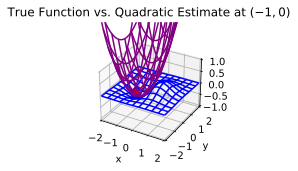

In [11]:
# Construct grid and compute the TRUE function
x, y = torch.meshgrid(torch.linspace(-2, 2, 101),
                      torch.linspace(-2, 2, 101))

z_true = x * torch.exp(-x**2 - y**2)  # The actual function we want to approximate

# Point where we estimate (expansion point)
x0, y0 = -1.0, 0.0

# Compute the QUADRATIC APPROXIMATION (2nd-order Taylor expansion) at (x0, y0)
# This is our ESTIMATE of the true function using only local information
# f(x,y) ≈ f(x0,y0) + ∇f·(x-x0, y-y0) + ½(x-x0, y-y0)ᵀ H (x-x0, y-y0)
z_estimate = torch.exp(torch.tensor([-1.])) * (-1 - (x - x0) + 2*(x - x0)**2 + 2*(y - y0)**2)

# Plot: Compare TRUE function vs ESTIMATED approximation
ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x.numpy(), y.numpy(), z_true.numpy(),
                  **{'rstride': 10, 'cstride': 10}, color='blue', label='True: $f(x,y)$')
ax.plot_wireframe(x.numpy(), y.numpy(), z_estimate.numpy(),
                  **{'rstride': 10, 'cstride': 10}, color='purple', label='Estimate: Taylor approx')
# Mark the expansion point where estimate = true
z0 = x0 * torch.exp(torch.tensor(-x0**2 - y0**2)).item()
ax.scatter([x0], [y0], [z0], color='red', s=100, marker='o')
d2l.plt.xlabel('x')
d2l.plt.ylabel('y')
d2l.set_figsize()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-1, 1)
ax.dist = 12
ax.set_title('True Function vs. Quadratic Estimate at $(-1, 0)$')

### A Little Matrix Calculus

This section covers matrix calculus — the rules for differentiating functions involving vectors and matrices. These rules are essential for understanding backpropagation and optimization in deep learning.

#### Scalar Functions of Vectors

Consider a function $f: \mathbb{R}^n \to \mathbb{R}$ that takes a vector and returns a scalar. The gradient is:

$$
\nabla_{\mathbf{x}} f(\mathbf{x}) = \begin{bmatrix} \frac{\partial f}{\partial x_1} \\ \frac{\partial f}{\partial x_2} \\ \vdots \\ \frac{\partial f}{\partial x_n} \end{bmatrix}
$$

#### Useful Identities

Here are some commonly used matrix calculus identities:

**For vectors $\mathbf{a}, \mathbf{x} \in \mathbb{R}^n$:**

$$
\nabla_{\mathbf{x}} \mathbf{a}^\top \mathbf{x} = \mathbf{a}
$$

$$
\nabla_{\mathbf{x}} \mathbf{x}^\top \mathbf{a} = \mathbf{a}
$$

$$
\nabla_{\mathbf{x}} \mathbf{x}^\top \mathbf{x} = 2\mathbf{x}
$$

**For a matrix $\mathbf{A} \in \mathbb{R}^{n \times n}$ and vector $\mathbf{x} \in \mathbb{R}^n$:**

$$
\nabla_{\mathbf{x}} \mathbf{x}^\top \mathbf{A} \mathbf{x} = (\mathbf{A} + \mathbf{A}^\top)\mathbf{x}
$$

If $\mathbf{A}$ is symmetric ($\mathbf{A} = \mathbf{A}^\top$):

$$
\nabla_{\mathbf{x}} \mathbf{x}^\top \mathbf{A} \mathbf{x} = 2\mathbf{A}\mathbf{x}
$$

**For matrix-vector products:**

$$
\nabla_{\mathbf{x}} \|\mathbf{A}\mathbf{x} - \mathbf{b}\|^2 = 2\mathbf{A}^\top(\mathbf{A}\mathbf{x} - \mathbf{b})
$$

#### Vector Functions of Vectors (Jacobians)

For a function $\mathbf{f}: \mathbb{R}^n \to \mathbb{R}^m$, the **Jacobian** matrix is:

$$
\mathbf{J} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}} = \begin{bmatrix} \frac{\partial f_1}{\partial x_1} & \cdots & \frac{\partial f_1}{\partial x_n} \\ \vdots & \ddots & \vdots \\ \frac{\partial f_m}{\partial x_1} & \cdots & \frac{\partial f_m}{\partial x_n} \end{bmatrix}
$$

**Useful Jacobian identities:**

$$
\frac{\partial}{\partial \mathbf{x}} (\mathbf{A}\mathbf{x}) = \mathbf{A}
$$

$$
\frac{\partial}{\partial \mathbf{x}} (\mathbf{x}^\top \mathbf{A}) = \mathbf{A}^\top
$$

#### Chain Rule for Vectors

If $\mathbf{y} = g(\mathbf{x})$ and $z = f(\mathbf{y})$, then:

$$
\nabla_{\mathbf{x}} z = \left(\frac{\partial \mathbf{y}}{\partial \mathbf{x}}\right)^\top \nabla_{\mathbf{y}} z = \mathbf{J}_g^\top \nabla_{\mathbf{y}} z
$$

This is the foundation of **backpropagation**: gradients flow backward through the transpose of Jacobians.

#### Scalar Functions of Matrices

For a function $f: \mathbb{R}^{m \times n} \to \mathbb{R}$, the gradient with respect to matrix $\mathbf{X}$ is:

$$
\nabla_{\mathbf{X}} f = \begin{bmatrix} \frac{\partial f}{\partial X_{11}} & \cdots & \frac{\partial f}{\partial X_{1n}} \\ \vdots & \ddots & \vdots \\ \frac{\partial f}{\partial X_{m1}} & \cdots & \frac{\partial f}{\partial X_{mn}} \end{bmatrix}
$$

**Useful identities:**

$$
\nabla_{\mathbf{X}} \text{tr}(\mathbf{X}) = \mathbf{I}
$$

$$
\nabla_{\mathbf{X}} \text{tr}(\mathbf{A}\mathbf{X}) = \mathbf{A}^\top
$$

$$
\nabla_{\mathbf{X}} \text{tr}(\mathbf{X}^\top \mathbf{A}) = \mathbf{A}
$$

$$
\nabla_{\mathbf{X}} \text{tr}(\mathbf{A}\mathbf{X}\mathbf{B}) = \mathbf{A}^\top \mathbf{B}^\top
$$

$$
\nabla_{\mathbf{X}} \|\mathbf{X}\|_F^2 = 2\mathbf{X}
$$

where $\|\mathbf{X}\|_F$ is the Frobenius norm.

#### Summary Table

| Expression | Gradient |
|------------|----------|
| $\mathbf{a}^\top \mathbf{x}$ | $\mathbf{a}$ |
| $\mathbf{x}^\top \mathbf{x}$ | $2\mathbf{x}$ |
| $\mathbf{x}^\top \mathbf{A} \mathbf{x}$ | $(\mathbf{A} + \mathbf{A}^\top)\mathbf{x}$ |
| $\lVert \mathbf{A}\mathbf{x} - \mathbf{b} \rVert^2$ | $2\mathbf{A}^\top(\mathbf{A}\mathbf{x} - \mathbf{b})$ |

#### Why This Matters for Deep Learning

- **Backpropagation** is just repeated application of the chain rule
- **Gradient descent** requires computing $\nabla_{\mathbf{W}} L$ for weight matrices
- These identities let us derive gradients for linear layers, loss functions, and regularization terms analytically

======================== Integral Calculus ========================

### Integral Calculus

This section reviews key concepts of **integral calculus** for functions of a single variable, focusing on interpretation, basic rules, and relationships with derivatives. Integral calculus provides tools for computing areas under curves, accumulated change, and definite/indefinite integrals.

#### Indefinite Integrals: Antiderivatives

An **indefinite integral** of a function $f(x)$ is a function $F(x)$ whose derivative is $f(x)$:

$$
F'(x) = f(x)
\quad\Longleftrightarrow\quad
F(x) = \int f(x)\,\mathrm{d}x.
$$

Indefinite integrals represent **families of antiderivatives**, differing by a constant:

$$
\int f(x)\,\mathrm{d}x
= F(x) + C,
$$

where $C$ is the **constant of integration**.

#### Basic Antiderivative Rules

Some common integrals:

- Power rule (for $n\neq -1$):

  $$
  \int x^n\,\mathrm{d}x = \frac{x^{n+1}}{n+1} + C
  $$

- Exponential:

  $$
  \int e^x\,\mathrm{d}x = e^x + C
  $$

- Constant multiple:

  $$
  \int c\,f(x)\,\mathrm{d}x
  = c\int f(x)\,\mathrm{d}x
  $$

- Sum:

  $$
  \int [f(x)+g(x)]\,\mathrm{d}x
  = \int f(x)\,\mathrm{d}x + \int g(x)\,\mathrm{d}x.
  $$

#### Definite Integrals: Accumulated Change

A **definite integral** from $a$ to $b$ measures the net accumulated change of $f(x)$ over $[a,b]$:

$$
\int_a^b f(x)\,\mathrm{d}x
= F(b)-F(a),
$$

where $F$ is an antiderivative of $f$.  
This is the **Fundamental Theorem of Calculus**.

#### Interpretation of Definite Integrals

- The definite integral computes **signed area** under $f(x)$ from $x=a$ to $x=b$.
- If $f(x)\ge 0$ on $[a,b]$, the integral equals the area under the graph.
- If $f(x)$ changes sign, positive and negative areas cancel.

#### Properties of Definite Integrals

Key properties:

- **Linearity**:

  $$
  \int_a^b [c\,f(x)]\,\mathrm{d}x
  = c\int_a^b f(x)\,\mathrm{d}x
  $$

  $$
  \int_a^b [f(x)+g(x)]\,\mathrm{d}x
  = \int_a^b f(x)\,\mathrm{d}x + \int_a^b g(x)\,\mathrm{d}x
  $$

- **Reversal rule**:

  $$
  \int_b^a f(x)\,\mathrm{d}x
  = -\int_a^b f(x)\,\mathrm{d}x
  $$

- **Additivity**:

  $$
  \int_a^b f(x)\,\mathrm{d}x
  + \int_b^c f(x)\,\mathrm{d}x
  = \int_a^c f(x)\,\mathrm{d}x.
  $$

#### Integral as Area

The definite integral can be interpreted as the **signed area** between the curve $y=f(x)$ and the $x$-axis:

- Above the axis → positive area
- Below the axis → negative area

This interpretation is useful for visualizing accumulation and net change.

#### Techniques of Integration (Basic)

- **Substitution Rule** (change of variables):

  If $u=g(x)$ with continuous derivative:

  $$
  \int f(g(x)) g'(x)\,\mathrm{d}x
  = \int f(u)\,\mathrm{d}u.
  $$

- This transforms difficult integrals into simpler ones.

#### Relationship to Derivatives

The **Fundamental Theorem of Calculus** connects integration and differentiation:

1. **Differentiating an integral**:

   If $F(x)=\int_a^x f(t)\,\mathrm{d}t$, then

   $$
   F'(x)=f(x).
   $$

2. **Evaluating a definite integral**:

   If $F$ is any antiderivative of $f$, then

   $$
   \int_a^b f(x)\,\mathrm{d}x = F(b)-F(a).
   $$

This unifies derivative and integral as inverse operations.

#### Summary

- **Indefinite integrals** represent families of antiderivatives.
- **Definite integrals** compute net accumulation (signed area).
- Fundamental rules (linearity, additivity, reversal) simplify manipulation.
- Substitution helps evaluate complex integrals.
- The Fundamental Theorem of Calculus bridges derivatives and integrals.

#### Multiple Integrals

Sometimes we need to integrate in higher dimensions. For example, for a function of two variables $f(x, y)$, we may want the **volume under the surface** over a rectangular domain where $x \in [a,b]$ and $y \in [c,d]$.

We write the double integral as:
$$
\int_{[a,b]\times[c,d]} f(x,y)\,dx\,dy.
$$

##### Iterated integrals (Fubini’s Theorem intuition)

A key claim is that we can compute this by integrating one variable at a time (an *iterated integral*):
$$
\int_{[a,b]\times[c,d]} f(x,y)\,dx\,dy
=
\int_c^d\left(\int_a^b f(x,y)\,dx\right)\,dy.
$$

**Why this makes sense (discretization idea):**
Split the rectangle into $\epsilon \times \epsilon$ squares. Then the integral is approximated by a Riemann sum:
$$
\sum_{i,j}\epsilon^2 f(\epsilon i, \epsilon j).
$$

Since it’s just a finite sum, we can rearrange the order of summation:
$$
\sum_j \epsilon \left(\sum_i \epsilon f(\epsilon i,\epsilon j)\right).
$$

**(Image placeholder: diagram showing summing squares by columns then adding columns.)**

The inner sum corresponds to integrating over $x$ at a fixed $y$:
$$
G(\epsilon j) = \int_a^b f(x, \epsilon j)\,dx,
$$
and then the outer sum approximates $\int_c^d G(y)\,dy$, giving:
$$
\int_{[a,b]\times[c,d]} f(x,y)\,dx\,dy
=
\int_c^d\left(\int_a^b f(x,y)\,dx\right)\,dy.
$$

You can also integrate in the opposite order:
$$
\int_{[a,b]\times[c,d]} f(x,y)\,dx\,dy
=
\int_a^b\left(\int_c^d f(x,y)\,dy\right)\,dx.
$$
Often we compress notation: for $U=[a,b]\times[c,d]$,
$$
\int_U f(\mathbf{x})\,d\mathbf{x}.
$$

> Note: The text mentions Fubini’s theorem can fail for pathological functions, but for the continuous functions typically used in ML, this is not a concern.

#### Change of Variables in Multiple Integrals

Just like the 1D substitution rule, we can change variables in higher-dimensional integrals. We summarize the result without full derivation.

Let $\phi:\mathbb{R}^n \to \mathbb{R}^n$ be a reparameterization (assume $\phi$ is injective so it doesn’t “fold” the domain). Then:
$$
\int_{\phi(U)} f(\mathbf{x})\,d\mathbf{x}
=
\int_U f(\phi(\mathbf{x}))\left|\det(D\phi(\mathbf{x}))\right|\,d\mathbf{x}.
$$

Here $D\phi$ is the **Jacobian matrix**:
$$
D\phi =
\begin{bmatrix}
\frac{\partial \phi_1}{\partial x_1} & \cdots & \frac{\partial \phi_1}{\partial x_n}\\
\vdots & \ddots & \vdots\\
\frac{\partial \phi_n}{\partial x_1} & \cdots & \frac{\partial \phi_n}{\partial x_n}
\end{bmatrix}.
$$

##### Intuition: why the determinant appears
In 1D, the factor $\frac{du}{dx}$ tells how much the mapping stretches the axis.  
In $n$D, $\left|\det(D\phi)\right|$ tells how much $\phi$ locally scales **volume** (area/volume/hyper-volume).

##### Example: Gaussian integral via polar coordinates
Consider:
$$
\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} e^{-x^2-y^2}\,dx\,dy.
$$

Use polar change of variables:
$$
\phi(r,\theta) = (r\cos\theta, r\sin\theta),
\quad x=r\cos\theta,\; y=r\sin\theta.
$$

Then:
$$
\int_{-\infty}^{\infty}\int_{-\infty}^{\infty} e^{-x^2-y^2}\,dx\,dy
=
\int_0^\infty \int_0^{2\pi} e^{-r^2}\left|\det(D\phi)\right|\,d\theta\,dr.
$$

Compute the Jacobian determinant:
$$
\left|\det(D\phi)\right|
=
\left|\det
\begin{bmatrix}
\cos\theta & -r\sin\theta\\
\sin\theta & r\cos\theta
\end{bmatrix}\right|
=
r(\cos^2\theta+\sin^2\theta)
=
r.
$$

So the integral becomes:
$$
\int_0^\infty \int_0^{2\pi} r e^{-r^2}\,d\theta\,dr
=
2\pi\int_0^\infty r e^{-r^2}\,dr
=
\pi.
$$

============================= Random Variables =============================

### Random Variables

This section introduces the basic concepts of **random variables**, their distributions, and key functions used to describe their behavior. These concepts underpin probabilistic modeling and statistical reasoning in machine learning.

#### What Is a Random Variable?

A **random variable** is a function that maps outcomes of a random process to real numbers.

- It is **not** a random process itself, but a way of assigning numbers to outcomes.
- Example: rolling a die and defining $X$ as the number shown.

There are two main types:

- **Discrete random variables:** take a countable set of values (e.g., die rolls).
- **Continuous random variables:** take values in uncountable ranges (e.g., real numbers).

#### Probability Mass Function (PMF)

For a **discrete** random variable $X$, the **probability mass function** $p(x)$ gives:

$$
p(x) = P(X = x).
$$

It satisfies:

- $p(x) \ge 0$ for all $x$,
- $\sum_{x} p(x) = 1$.

This function tells how probability is distributed over possible values.

#### Cumulative Distribution Function (CDF)

The **cumulative distribution function** $F(x)$ is defined for any random variable (discrete or continuous) as:

$$
F(x) = P(X \le x).
$$

Properties of $F(x)$:

- nondecreasing,
- right-continuous,
- $\lim_{x\to -\infty} F(x)=0$,
- $\lim_{x\to +\infty} F(x)=1$.

For discrete $X$, $F(x)$ jumps at each possible value; for continuous $X$, it is smooth.

#### Probability Density Function (PDF)

For a **continuous** random variable, the **probability density function** $f(x)$ satisfies:

$$
P(a < X \le b) = \int_a^b f(x)\,\mathrm{d}x,
$$

and:

- $f(x)\ge 0$,
- $\int_{-\infty}^{\infty} f(x)\,\mathrm{d}x = 1$.

Unlike the PMF, $f(x)$ itself doesn’t give probabilities — areas under the curve do.

The PDF and CDF are related by:

$$
F(x) = \int_{-\infty}^{x} f(t)\,\mathrm{d}t.
$$

And, if $F$ is differentiable:

$$
f(x)=F'(x).
$$

#### Expectation (Mean)

The **expected value** (or mean) of a random variable $X$ quantifies its average outcome.

- For discrete $X$:

  $$
  \mathbb{E}[X] = \sum_x x\,p(x).
  $$

- For continuous $X$:

  $$
  \mathbb{E}[X] = \int_{-\infty}^\infty x\,f(x)\,\mathrm{d}x.
  $$

Expectation is **linear**, i.e.,

$$
\mathbb{E}[aX+bY]=a\mathbb{E}[X]+b\mathbb{E}[Y].
$$

#### Variance

Variance quantifies spread around the mean:

$$
\mathrm{Var}(X) = \mathbb{E}[(X-\mathbb{E}[X])^2].
$$

It can also be computed as:

$$
\mathrm{Var}(X)=\mathbb{E}[X^2] - (\mathbb{E}[X])^2.
$$

Larger variance means greater dispersion.

#### A Few Common Distributions

- **Bernoulli($p$):** takes value 1 with probability $p$, 0 with probability $1-p$.
  - $\mathbb{E}[X]=p$, $\mathrm{Var}(X)=p(1-p)$.
- **Binomial($n,p$):** sum of $n$ independent Bernoullis.
  - $\mathbb{E}[X]=np$, $\mathrm{Var}(X)=np(1-p)$.
- **Uniform continuous on $[a,b]$:**
  - $f(x)=\frac{1}{b-a}$ on $[a,b]$, otherwise 0.
  - $\mathbb{E}[X]=\frac{a+b}{2}$, $\mathrm{Var}(X)=\frac{(b-a)^2}{12}$.
- **Normal($\mu,\sigma^2$):**
  - bell-shaped PDF:
    $$
    f(x)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-(x-\mu)^2/(2\sigma^2)},
    $$
  - $\mathbb{E}[X]=\mu$, $\mathrm{Var}(X)=\sigma^2$.

#### Indicator Random Variables

An **indicator** of an event $A$ is:

$$
I_A = \begin{cases}
1,&\text{if }A\text{ occurs},\\
0,&\text{otherwise}.
\end{cases}
$$

Expectations help count events:

$$
\mathbb{E}[I_A]=P(A).
$$

#### Law of the Unconscious Statistician (LOTUS)

To compute $\mathbb{E}[g(X)]$ for a function $g$ of a random variable:

- Discrete:

  $$
  \mathbb{E}[g(X)] = \sum_x g(x)p(x).
  $$

- Continuous:

  $$
  \mathbb{E}[g(X)] = \int_{-\infty}^\infty g(x)f(x)\,\mathrm{d}x.
  $$

#### Summary

- Random variables map outcomes to numbers.
- PMF, PDF, and CDF describe probability distributions.
- Expectation and variance quantify central tendency and spread.
- Common distributions (Bernoulli, binomial, uniform, normal) appear frequently in ML.
- Indicator variables and LOTUS are useful tools for expectation computations.

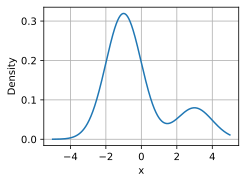

In [9]:
%matplotlib inline
import torch
from IPython import display
from d2l import torch as d2l

torch.pi = torch.acos(torch.zeros(1)).item() * 2  # Define pi in torch

# Plot the probability density function for some random variable
x = torch.arange(-5, 5, 0.01)
p = 0.2*torch.exp(-(x - 3)**2 / 2)/torch.sqrt(2 * torch.tensor(torch.pi)) + \
    0.8*torch.exp(-(x + 1)**2 / 2)/torch.sqrt(2 * torch.tensor(torch.pi))

d2l.plot(x, p, 'x', 'Density')

#### Standard Deviations
Standard deviation is defined as the square root of variance:
$$
\sigma_X = \sqrt{\mathrm{Var}(X)}.
$$
￼
- Unit interpretation: unlike variance (units squared), $\sigma_X$ is in the same units as $X$.  ￼
- Properties (mirroring variance):
  - $\sigma_X \ge 0$
  - $\sigma_{aX+b} = |a| * \sigma_X$
  - If $X,Y$ independent: $\sigma_{X+Y} = \sqrt{\sigma_X^2+\sigma_Y^2}$
- Chebyshev’s inequality gives a rigorous “typical range” meaning:
$
P\left(|X - \mu_X| \geq \alpha\sigma_X\right) \leq \frac{1}{\alpha^2}
$ or $P\left(X \notin [\mu_X - \alpha\sigma_X,\ \mu_X + \alpha\sigma_X]\right) \leq \frac{1}{\alpha^2}$.
So e.g. with $\alpha=10$, at least $99%$ of samples fall within $10\sigma$ of the mean.  ￼

#### Means and Variances in the Continuum
For a continuous random variable with density $p_X(x)$, expectations become integrals (the discrete sums turn into Riemann sums → integrals).  ￼
Mean:
$$
\mu_X = \int_{-\infty}^{\infty} x p_X(x) dx.
$$
￼
Variance (via $E[X^2] - \mu_X^2$):
$$
\sigma_X^2
= \int_{-\infty}^{\infty} x^2 p_X(x) dx - \left(\int_{-\infty}^{\infty} x p_X(x) dx\right)^2
$$
￼
Example: Uniform on $[0,1]$: $\mu_X = 1/2$, $\sigma_X^2 = 1/12$  ￼

Warning: 
heavy-tailed distributions can have undefined mean/variance.
Example: Cauchy with $p(x)=\frac{1}{1+x^2}$ has no finite mean and no finite variance (the integrals diverge).  ￼
In ML practice, we usually choose models/distributions where mean/variance are well-defined, but it’s useful to know exceptions exist.  ￼

#### Joint Density Functions
For two continuous random variables $(X,Y)$, define a joint density $p_{X,Y}(x,y)$ so that small-box probabilities behave like:
$$
P(X\text{ near }x,\ Y\text{ near }y) \approx \epsilon^2 p(x,y).
$$
￼
Joint density properties:
- $p(x,y)\ge 0$
- $\int_{\mathbb{R}^2} p(x,y) dx dy = 1$
- For region $\mathcal{D}$:
$P((X,Y)\in \mathcal{D})=\int_{\mathcal{D}} p(x,y) dx dy$
- Extends to higher dimensions: $p(\mathbf{x})=p(x_1,\dots,x_n)$ with the same “nonnegative + integrates to 1” idea.  ￼

#### Marginal Distributions
Goal: from joint density $p_{X,Y}(x,y)$ to get the distribution of $X$ alone: $p_X(x)$.  ￼

Idea: probability of $X$ near $x$ regardless of $Y$ means you integrate over all $y$ (“integrate out” the unwanted variable):
$p_X(x) = \int_{-\infty}^{\infty} p_{X,Y}(x,y) dy$
￼
#### Covariance
Covariance measures how two random variables vary together.

For discrete $(X,Y)$ (values $(x_i,y_j)$ with prob $p_{ij}$):
$$
\mathrm{Cov}(X,Y)=\sum_{i,j}(x_i-\mu_X)(y_j-\mu_Y)p_{ij}
= E[XY]-E[X]E[Y].
$$
￼
Key properties:
- $\mathrm{Cov}(X,X)=\mathrm{Var}(X)$
- $\mathrm{Cov}(aX+b,\ Y)=a \mathrm{Cov}(X,Y)$ (and similarly in the other argument)
- If $X$ and $Y$ are independent, then $\mathrm{Cov}(X,Y)=0$  ￼
- Variance of a sum (general case):
$\mathrm{Var}(X+Y)=\mathrm{Var}(X)+\mathrm{Var}(Y)+2\mathrm{Cov}(X,Y).$
￼
#### Correlation
Covariance depends on units (e.g., inches × dollars), which is hard to interpret.

Correlation normalizes covariance by standard deviations to make it unitless:
$$
\rho(X,Y)=\frac{\mathrm{Cov}(X,Y)}{\sigma_X\sigma_Y}.
$$
￼
Facts:
- $\rho(X,Y)\in[-1,1]$
- $\rho(X,X)=1$
- $\rho(aX+b,\ Y)=\rho(X,\ aY+b)=\rho(X,Y)$
- If $X,Y$ independent and variances non-zero, then $\rho(X,Y)=0$  ￼
- Nice geometric intuition: correlation resembles a cosine similarity (cosine of an “angle” between weighted vectors), which helps transfer geometric intuition to probability/statistics.

#### Visualizing Chebyshev's Inequality

To understand Chebyshev's inequality intuitively, we use a **3-point discrete distribution**:
- $P(X = a-2) = p$
- $P(X = a) = 1 - 2p$  
- $P(X = a+2) = p$

This symmetric distribution has:
- **Mean**: $\mu = a$
- **Variance**: $\sigma^2 = 8p$, so $\sigma = 2\sqrt{2p}$

Using Chebyshev with $\alpha = 2$:
$$P\left(X \notin [a - 2\sigma,\ a + 2\sigma]\right) \leq \frac{1}{4}$$

Since $2\sigma = 4\sqrt{2p}$, the interval is $[a - 4\sqrt{2p},\ a + 4\sqrt{2p}]$.

**Key insight**: At $p = 1/8$, we have $4\sqrt{2p} = 4\sqrt{1/4} = 2$, so the interval **exactly** reaches the outer points at $a \pm 2$. This is where Chebyshev's bound is **tight** (equality holds).

In [21]:
# ============================================================================
# VISUALIZING CHEBYSHEV'S INEQUALITY
# ============================================================================
# Chebyshev says: P(|X - mu| >= alpha*sigma) <= 1/alpha^2
# 
# Using alpha=2: P(|X - a| >= 2*sigma) <= 1/4 = 25%
# This means at least 75% of probability lies within 2 standard deviations.
#
# For our 3-point distribution:
#   sigma^2 = 8p  =>  sigma = sqrt(8p) = 2*sqrt(2p)
#   2*sigma = 4*sqrt(2p)
#
# The horizontal bar shows the interval [mu - 2*sigma, mu + 2*sigma]
# = [a - 4*sqrt(2p), a + 4*sqrt(2p)]
# ============================================================================

def plot_chebyshev(a, p):
    """
    Plot a 3-point distribution and its 2-sigma interval.
    
    Args:
        a: center (mean) of the distribution
        p: probability of the outer points (X = a +/- 2)
    
    The black horizontal bar shows [mu - 2*sigma, mu + 2*sigma].
    Chebyshev guarantees at least 75% probability within this interval.
    """
    d2l.set_figsize()
    d2l.plt.stem([a-2, a, a+2], [p, 1-2*p, p], use_line_collection=True)
    d2l.plt.xlim([-4, 4])
    d2l.plt.xlabel('x')
    d2l.plt.ylabel('p.m.f.')

    # 2-sigma interval: sigma = 2*sqrt(2p), so 2*sigma = 4*sqrt(2p)
    two_sigma = 4 * torch.sqrt(2 * p)
    d2l.plt.hlines(0.5, a - two_sigma, a + two_sigma, 'black', lw=4)
    d2l.plt.vlines(a - two_sigma, 0.53, 0.47, 'black', lw=1)
    d2l.plt.vlines(a + two_sigma, 0.53, 0.47, 'black', lw=1)
    d2l.plt.title(f'p = {p:.3f}')

    d2l.plt.show()

/tmp/ipykernel_2846/3898607311.py:29: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  d2l.plt.stem([a-2, a, a+2], [p, 1-2*p, p], use_line_collection=True)


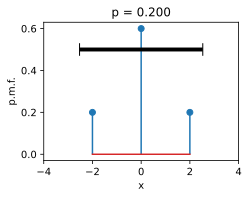

In [22]:
# CASE 1: p = 0.2 (p > 1/8)
# sigma = 2*sqrt(2*0.2) = 2*sqrt(0.4) = 1.265
# 2*sigma = 4*sqrt(0.4) = 2.53
# The 2*sigma interval is [-2.53, 2.53], which covers the outer points at +/-2
# --> ALL probability (100%) is captured within 2*sigma, satisfying Chebyshev's >= 75%
plot_chebyshev(0.0, torch.tensor(0.2))

/tmp/ipykernel_2846/3898607311.py:29: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  d2l.plt.stem([a-2, a, a+2], [p, 1-2*p, p], use_line_collection=True)


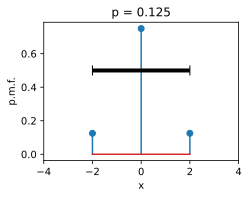

In [23]:
# CASE 2: p = 0.125 = 1/8 (BOUNDARY CASE - the inequality is SHARP here!)
# sigma = 2*sqrt(2*0.125) = 2*sqrt(0.25) = 2*0.5 = 1
# 2*sigma = 4*sqrt(0.25) = 4*0.5 = 2
# The 2*sigma interval is EXACTLY [-2, 2], which just touches the outer points!
# --> Probability outside = 2p = 0.25 = exactly 1/4, matching Chebyshev's bound!
# This is the "worst case" distribution where Chebyshev is tight.
plot_chebyshev(0.0, torch.tensor(0.125))

/tmp/ipykernel_2846/3898607311.py:29: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  d2l.plt.stem([a-2, a, a+2], [p, 1-2*p, p], use_line_collection=True)


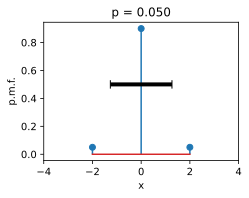

In [24]:
# CASE 3: p = 0.05 (p < 1/8)
# sigma = 2*sqrt(2*0.05) = 2*sqrt(0.1) = 0.632
# 2*sigma = 4*sqrt(0.1) = 1.265
# The 2*sigma interval is [-1.265, 1.265], which does NOT cover the outer points at +/-2!
# --> Only the center point (prob = 1-2p = 0.9) is inside the interval
# --> Probability outside = 2p = 0.10, which is LESS than Chebyshev's bound of 1/4
# This is fine - Chebyshev only guarantees <= 1/4 outside, and 0.10 < 0.25.
plot_chebyshev(0.0, torch.tensor(0.05))

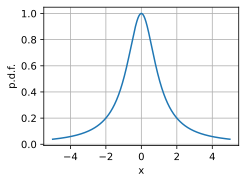

In [25]:
# Plot the Cauchy distribution p.d.f.
x = torch.arange(-5, 5, 0.01)
p = 1 / (1 + x**2)

d2l.plot(x, p, 'x', 'p.d.f.')

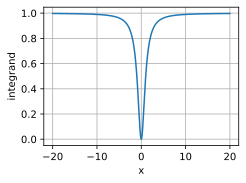

In [26]:
# Plot the integrand needed to compute the variance
x = torch.arange(-20, 20, 0.01)
p = x**2 / (1 + x**2)

d2l.plot(x, p, 'x', 'integrand')

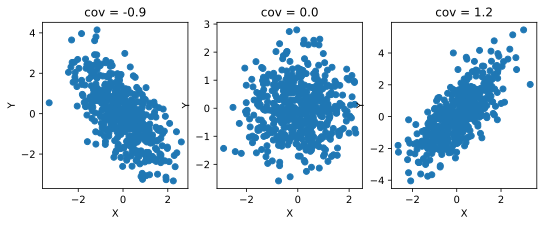

In [27]:
# Plot a few random variables adjustable covariance
covs = [-0.9, 0.0, 1.2]
d2l.plt.figure(figsize=(12, 3))
for i in range(3):
    X = torch.randn(500)
    Y = covs[i]*X + torch.randn(500)

    d2l.plt.subplot(1, 4, i+1)
    d2l.plt.scatter(X.numpy(), Y.numpy())
    d2l.plt.xlabel('X')
    d2l.plt.ylabel('Y')
    d2l.plt.title(f'cov = {covs[i]}')
d2l.plt.show()

======================== Maximum Likelihood ========================

### Maximum Likelihood Estimation (MLE)

Maximum likelihood is one of the most fundamental concepts in machine learning for parameter estimation.

#### The Core Principle

**Goal**: Find parameter values $\boldsymbol{\theta}$ that make the observed data most probable:

$$\hat{\boldsymbol{\theta}} = \mathop{\mathrm{argmax}}_{\boldsymbol{\theta}} P(X \mid \boldsymbol{\theta})$$

The term $P(X \mid \boldsymbol{\theta})$ is called the **likelihood**.

#### Bayesian Interpretation

Using Bayes' rule:
$$P(\boldsymbol{\theta} \mid X) = \frac{P(X \mid \boldsymbol{\theta}) P(\boldsymbol{\theta})}{P(X)}$$

With an **uninformative prior** (no preference for any $\boldsymbol{\theta}$), maximizing the posterior reduces to maximizing the likelihood.

#### Concrete Example: Coin Flipping

For $n_H$ heads and $n_T$ tails with probability $\theta$ of heads:
$$P(X \mid \theta) = \theta^{n_H}(1-\theta)^{n_T}$$

Taking the derivative and setting to zero:
$$\frac{d}{d\theta} \theta^{n_H}(1-\theta)^{n_T} = 0 \implies \hat{\theta} = \frac{n_H}{n_H + n_T}$$

This matches intuition: if you flip 13 coins and get 9 heads, the MLE is $\hat{\theta} = 9/13$.

#### Why Use Negative Log-Likelihood?

Instead of maximizing $P(X \mid \boldsymbol{\theta})$, we minimize $-\log P(X \mid \boldsymbol{\theta})$ for three reasons:

**1. Numerical Stability**
Products of small probabilities cause underflow:
- $(0.5)^{1000000000} \approx 0$ (underflows!)
- $1000000000 \cdot \log(0.5) \approx -3 \times 10^8$ (computable)

**2. Computational Efficiency**
- Gradient of products: $O(n^2)$ operations
- Gradient of sums: $O(n)$ operations

Log converts products to sums:
$$-\log P(X \mid \boldsymbol{\theta}) = -\sum_i \log P(x_i \mid \boldsymbol{\theta})$$

**3. Information Theory Connection**

Recall the definitions:
- **Entropy**: $H(P) = -\sum_x P(x) \log P(x)$ — the uncertainty in the true distribution
- **Cross-Entropy**: $H(P, Q) = -\sum_x P(x) \log Q(x)$ — average bits needed to encode samples from $P$ using code optimized for $Q$

**Why average NLL = cross-entropy:**

When we compute the **average** negative log-likelihood over $N$ i.i.d. samples from the true distribution $P$:

$$\text{Avg NLL} = -\frac{1}{N} \sum_{i=1}^{N} \log Q(x_i)$$

By grouping samples by their value and using the empirical frequency $\hat{P}(x) = \frac{\text{count}(x)}{N}$:

$$= -\sum_x \frac{\text{count}(x)}{N} \log Q(x) = -\sum_x \hat{P}(x) \log Q(x) = H(\hat{P}, Q)$$

As $N \to \infty$, the empirical distribution $\hat{P} \to P$, so:

$$\text{Avg NLL} \to H(P, Q) \quad \text{(cross-entropy)}$$

**Why this matters for ML:**
- Cross-entropy satisfies $H(P, Q) \geq H(P)$, with equality **only when** $Q = P$
- The gap $H(P, Q) - H(P) = D_{KL}(P \| Q) \geq 0$ is the KL divergence
- Minimizing cross-entropy pushes our model $Q$ toward the true distribution $P$

#### Continuous Variables

Replace probabilities with **probability densities**:
$$-\log p(X \mid \boldsymbol{\theta}) = -\sum_i \log p(x_i \mid \boldsymbol{\theta})$$

The math works identically — matching to within $\epsilon$ leads to terms that cancel when optimizing.

#### Connection to Loss Functions

| Problem | Likelihood | Loss Function |
|---------|-----------|---------------|
| Regression (Gaussian noise) | $\prod_i \exp\left(-\frac{(y_i - \hat{y}_i)^2}{2\sigma^2}\right)$ | Mean Squared Error |
| Binary Classification | $\prod_i \pi_i^{y_i}(1-\pi_i)^{1-y_i}$ | Binary Cross-Entropy |
| Multi-class Classification | $\prod_i \prod_j \pi_{ij}^{y_{ij}}$ | Cross-Entropy Loss |

#### Summary

- **MLE Principle**: Best model = highest probability of generating observed data
- **Use negative log-likelihood** for numerical stability and computational efficiency
- **Works for both** discrete and continuous distributions
- **Foundation** for common loss functions (MSE, cross-entropy)

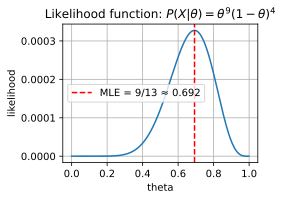

In [28]:
# ============================================================================
# VISUALIZING THE LIKELIHOOD FUNCTION
# ============================================================================
# Example: Flipping 13 coins, observed 9 heads and 4 tails
# Likelihood: P(X | theta) = theta^9 * (1-theta)^4
# What value of theta maximizes this?

theta = torch.arange(0, 1, 0.001)
p = theta**9 * (1 - theta)**4

d2l.plot(theta, p, 'theta', 'likelihood')
d2l.plt.title('Likelihood function: $P(X|\\theta) = \\theta^9(1-\\theta)^4$')
d2l.plt.axvline(x=9/13, color='r', linestyle='--', label=f'MLE = 9/13 ≈ {9/13:.3f}')
d2l.plt.legend()

In [29]:
# ============================================================================
# NUMERICAL OPTIMIZATION USING NEGATIVE LOG-LIKELIHOOD
# ============================================================================
# For large datasets, we use gradient descent on the negative log-likelihood
# instead of directly maximizing the likelihood (to avoid numerical underflow)

# Set up our data: 8,675,309 heads and 256,245 tails
n_H = 8675309
n_T = 256245

# Initialize our parameter
theta = torch.tensor(0.5, requires_grad=True)

# Perform gradient descent on NEGATIVE LOG-LIKELIHOOD
# -log P(X|theta) = -(n_H * log(theta) + n_T * log(1-theta))
lr = 1e-9
for iter in range(100):
    loss = -(n_H * torch.log(theta) + n_T * torch.log(1 - theta))
    loss.backward()
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.grad.zero_()

# Compare: gradient descent result vs closed-form MLE
print(f"Gradient descent estimate: {theta.item():.6f}")
print(f"Closed-form MLE (n_H/(n_H+n_T)): {n_H / (n_H + n_T):.6f}")

Gradient descent estimate: 0.971310
Closed-form MLE (n_H/(n_H+n_T)): 0.971310


In [30]:
# ============================================================================
# WHY LOG-LIKELIHOOD? NUMERICAL STABILITY DEMONSTRATION
# ============================================================================
# Direct likelihood computation causes underflow for large datasets
# Log-likelihood stays in a reasonable numerical range

import math

a = 0.1
print(f"Direct computation: {a}^784 = {a**784}")  # Underflows to 0!
print(f"Log computation: 784 * log({a}) = {784 * math.log(a):.2f}")  # Works fine!

Direct computation: 0.1^784 = 0.0
Log computation: 784 * log(0.1) = -1805.23


================================  Distributions ================================

#### 1. Bernoulli Distribution

The simplest random variable, modeling a binary outcome (coin flip).

**Notation:** $X \sim \text{Bernoulli}(p)$

**PMF:**
$$P(X = x) = \begin{cases} p & \text{if } x = 1 \\ 1-p & \text{if } x = 0 \end{cases}$$

**CDF:**
$$F(x) = \begin{cases} 0 & x < 0 \\ 1-p & 0 \le x < 1 \\ 1 & x \ge 1 \end{cases}$$

**Key Properties:**
- **Mean:** $\mu_X = p$
- **Variance:** $\sigma_X^2 = p(1-p)$
- Models yes/no outcomes

/tmp/ipykernel_2131/2201361769.py:12: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  d2l.plt.stem([0, 1], [1 - p, p], use_line_collection=True)


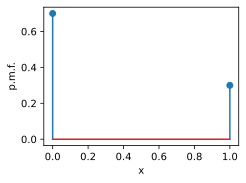

In [1]:
%matplotlib inline
from math import erf, factorial
import torch
from IPython import display
from d2l import torch as d2l

torch.pi = torch.acos(torch.zeros(1)) * 2  # Define pi in torch

p = 0.3

d2l.set_figsize()
d2l.plt.stem([0, 1], [1 - p, p], use_line_collection=True)
d2l.plt.xlabel('x')
d2l.plt.ylabel('p.m.f.')
d2l.plt.show()

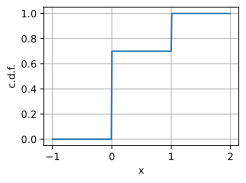

In [2]:
x = torch.arange(-1, 2, 0.01)

def F(x):
    return 0 if x < 0 else 1 if x > 1 else 1 - p

d2l.plot(x, torch.tensor([F(y) for y in x]), 'x', 'c.d.f.')

#### 2. Discrete Uniform Distribution

Models equally likely selection from a finite set of values.

**Notation:** $X \sim U(n)$ for integers $\{1, 2, \ldots, n\}$

**PMF:**
$$P(X = k) = \frac{1}{n} \quad \text{for } k \in \{1, 2, \ldots, n\}$$

**CDF:**
$$F(x) = \begin{cases} 0 & x < 1 \\ \frac{\lfloor x \rfloor}{n} & 1 \le x < n \\ 1 & x \ge n \end{cases}$$

**Key Properties:**
- **Mean:** $\mu_X = \frac{1+n}{2}$
- **Variance:** $\sigma_X^2 = \frac{n^2-1}{12}$
- Every outcome equally likely

/tmp/ipykernel_2131/956065247.py:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  d2l.plt.stem([i+1 for i in range(n)], n*[1 / n], use_line_collection=True)


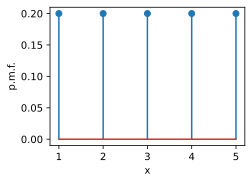

In [3]:
n = 5

d2l.plt.stem([i+1 for i in range(n)], n*[1 / n], use_line_collection=True)
d2l.plt.xlabel('x')
d2l.plt.ylabel('p.m.f.')
d2l.plt.show()

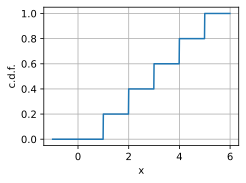

In [4]:
x = torch.arange(-1, 6, 0.01)

def F(x):
    return 0 if x < 1 else 1 if x > n else torch.floor(x) / n

d2l.plot(x, torch.tensor([F(y) for y in x]), 'x', 'c.d.f.')

In [5]:
# We can sample an array of arbitrary shape from a discrete uniform random variable as follows.

torch.randint(1, n, size=(10, 10))

tensor([[1, 2, 2, 2, 4, 3, 3, 4, 2, 1],
        [2, 2, 2, 4, 1, 1, 4, 3, 4, 3],
        [2, 1, 1, 3, 4, 1, 3, 2, 4, 1],
        [3, 1, 4, 2, 1, 3, 2, 3, 3, 3],
        [3, 1, 3, 1, 3, 4, 4, 2, 2, 3],
        [3, 1, 2, 2, 4, 2, 4, 4, 2, 3],
        [2, 1, 1, 3, 1, 3, 4, 1, 3, 4],
        [3, 3, 1, 1, 4, 4, 2, 3, 4, 2],
        [3, 2, 3, 3, 2, 4, 4, 1, 3, 3],
        [4, 3, 1, 3, 1, 3, 3, 2, 1, 3]])

#### 3. Continuous Uniform Distribution

Continuous version: picks any value in interval $[a, b]$ with equal probability.

**Notation:** $X \sim U(a, b)$

**PDF:**
$$p(x) = \begin{cases} \frac{1}{b-a} & x \in [a, b] \\ 0 & \text{otherwise} \end{cases}$$

**CDF:**
$$F(x) = \begin{cases} 0 & x < a \\ \frac{x-a}{b-a} & x \in [a, b] \\ 1 & x > b \end{cases}$$

**Key Properties:**
- **Mean:** $\mu_X = \frac{a+b}{2}$
- **Variance:** $\sigma_X^2 = \frac{(b-a)^2}{12}$
- Commonly used for random initialization

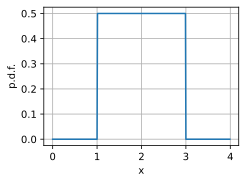

In [6]:
a, b = 1, 3

x = torch.arange(0, 4, 0.01)
p = (x > a).type(torch.float32)*(x < b).type(torch.float32)/(b-a)
d2l.plot(x, p, 'x', 'p.d.f.')

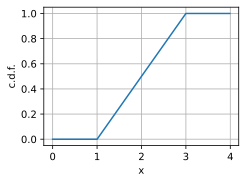

In [7]:
def F(x):
    return 0 if x < a else 1 if x > b else (x - a) / (b - a)

d2l.plot(x, torch.tensor([F(y) for y in x]), 'x', 'c.d.f.')

In [8]:
# We can sample an array of arbitrary shape from a uniform random variable as follows. Note that it 
# by default samples from a U(0,1), so if we want a different range we need to scale it.

(b - a) * torch.rand(10, 10) + a

tensor([[1.7473, 1.0853, 2.5994, 1.8291, 1.5740, 2.7724, 2.3466, 2.0048, 2.3200,
         2.5839],
        [1.4573, 2.8137, 1.1162, 1.9226, 1.2882, 2.7702, 2.2458, 1.1090, 2.4403,
         1.8452],
        [1.0111, 2.7965, 1.2671, 2.5340, 1.2920, 2.8975, 1.3476, 2.5770, 1.1031,
         2.9164],
        [1.9015, 2.1537, 1.1519, 2.3789, 2.6858, 2.3578, 2.3692, 1.0182, 1.9650,
         2.7887],
        [2.1464, 2.5011, 1.9280, 2.6596, 2.8491, 1.2205, 1.6126, 1.4637, 2.3478,
         2.6662],
        [1.9010, 1.3968, 1.1531, 2.6114, 1.7985, 1.2697, 2.3475, 1.0458, 2.5350,
         2.0382],
        [1.3902, 1.2008, 1.2376, 2.1664, 2.6523, 2.2829, 1.2541, 2.8264, 2.7213,
         2.8165],
        [2.2781, 2.0656, 1.9888, 2.4083, 1.7465, 1.3486, 2.5936, 1.3990, 2.3714,
         2.7862],
        [2.5818, 2.1565, 1.7676, 1.8301, 1.3195, 1.3785, 2.2535, 1.6443, 2.2731,
         2.6925],
        [2.0084, 1.0704, 2.0129, 2.4410, 2.2518, 1.2208, 1.1457, 2.1121, 2.2652,
         1.4805]])

#### 4. Binomial Distribution

Models the number of successes in $n$ independent Bernoulli trials.

**Notation:** $X \sim \text{Binomial}(n, p)$

**PMF:**
$$P(X = k) = \binom{n}{k} p^k (1-p)^{n-k}$$

where $\binom{n}{k} = \frac{n!}{k!(n-k)!}$

**Key Properties:**
- **Mean:** $\mu_X = np$
- **Variance:** $\sigma_X^2 = np(1-p)$
- Sum of $n$ i.i.d. Bernoulli random variables: $X = \sum_{i=1}^n X_i$ where $X_i \sim \text{Bernoulli}(p)$

/tmp/ipykernel_2131/2490357795.py:12: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  d2l.plt.stem([i for i in range(n + 1)], pmf, use_line_collection=True)


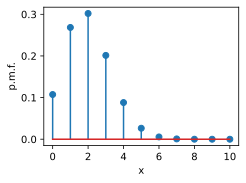

In [9]:
n, p = 10, 0.2

# Compute binomial coefficient
def binom(n, k):
    comb = 1
    for i in range(min(k, n - k)):
        comb = comb * (n - i) // (i + 1)
    return comb

pmf = torch.tensor([p**i * (1-p)**(n - i) * binom(n, i) for i in range(n + 1)])

d2l.plt.stem([i for i in range(n + 1)], pmf, use_line_collection=True)
d2l.plt.xlabel('x')
d2l.plt.ylabel('p.m.f.')
d2l.plt.show()

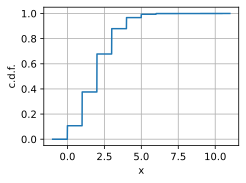

In [10]:
x = torch.arange(-1, 11, 0.01)
cmf = torch.cumsum(pmf, dim=0)

def F(x):
    return 0 if x < 0 else 1 if x > n else cmf[int(x)]

d2l.plot(x, torch.tensor([F(y) for y in x.tolist()]), 'x', 'c.d.f.')

In [11]:
m = torch.distributions.binomial.Binomial(n, p)
m.sample(sample_shape=(10, 10))

tensor([[2., 1., 1., 1., 2., 1., 3., 2., 1., 3.],
        [2., 2., 1., 4., 2., 0., 2., 1., 1., 0.],
        [2., 1., 3., 2., 3., 2., 3., 0., 2., 1.],
        [3., 2., 3., 0., 2., 3., 3., 0., 2., 0.],
        [3., 1., 2., 2., 4., 1., 1., 5., 3., 0.],
        [1., 1., 2., 0., 1., 1., 3., 0., 1., 1.],
        [2., 3., 3., 1., 0., 4., 4., 2., 2., 3.],
        [6., 2., 3., 5., 1., 1., 3., 4., 2., 2.],
        [1., 2., 1., 1., 2., 4., 2., 0., 1., 2.],
        [1., 2., 1., 3., 3., 0., 2., 3., 1., 4.]])

#### 5. Poisson Distribution

Models the count of rare events occurring in a fixed time/space interval.

**Notation:** $X \sim \text{Poisson}(\lambda)$

**PMF:**
$$P(X = k) = \frac{\lambda^k e^{-\lambda}}{k!} \quad \text{for } k = 0, 1, 2, \ldots$$

**CDF:**
$$F(x) = e^{-\lambda} \sum_{m=0}^{\lfloor x \rfloor} \frac{\lambda^m}{m!}$$

**Key Properties:**
- **Mean:** $\mu_X = \lambda$
- **Variance:** $\sigma_X^2 = \lambda$
- Arises as limit of $\text{Binomial}(n, p/n)$ as $n \to \infty$ (law of rare events)
- $\lambda$ is the *rate parameter* (expected arrivals per unit time)

/tmp/ipykernel_2131/652187134.py:7: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  d2l.plt.stem(xs, pmf, use_line_collection=True)


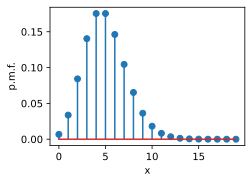

In [13]:
lam = 5.0

xs = [i for i in range(20)]
pmf = torch.tensor([torch.exp(torch.tensor(-lam)) * lam**k
                    / factorial(k) for k in xs])

d2l.plt.stem(xs, pmf, use_line_collection=True)
d2l.plt.xlabel('x')
d2l.plt.ylabel('p.m.f.')
d2l.plt.show()

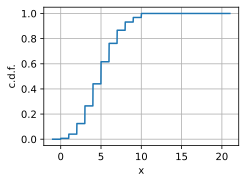

In [14]:
x = torch.arange(-1, 21, 0.01)
cmf = torch.cumsum(pmf, dim=0)
def F(x):
    return 0 if x < 0 else 1 if x > n else cmf[int(x)]

d2l.plot(x, torch.tensor([F(y) for y in x.tolist()]), 'x', 'c.d.f.')

In [15]:
m = torch.distributions.poisson.Poisson(lam)
m.sample((10, 10))

tensor([[ 0.,  6.,  5.,  3.,  7.,  0.,  3.,  2.,  3.,  5.],
        [ 8.,  5.,  6.,  8.,  4.,  6.,  6.,  3., 10., 10.],
        [ 3.,  2.,  3.,  6.,  7.,  4.,  5.,  5.,  4.,  2.],
        [ 9.,  3.,  5.,  5.,  3.,  3.,  4., 10.,  6.,  4.],
        [ 4.,  1.,  3.,  5.,  4.,  3.,  3.,  5.,  9.,  3.],
        [ 3.,  8.,  4.,  5.,  4.,  5.,  5.,  4., 10.,  5.],
        [ 9.,  1.,  4.,  5.,  3.,  3.,  0.,  3.,  7.,  7.],
        [ 4.,  4.,  4.,  5.,  1.,  8.,  5., 13.,  8.,  1.],
        [ 6.,  6.,  4.,  5.,  3.,  5.,  4.,  4.,  2.,  4.],
        [ 5.,  8.,  8.,  6.,  8.,  8.,  4.,  4.,  4.,  6.]])

#### 6. Gaussian (Normal) Distribution

The most important continuous distribution in statistics and ML.

**Notation:** $X \sim \mathcal{N}(\mu, \sigma^2)$

**PDF:**
$$p(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$$

**CDF:**
$$\Phi(x) = \frac{1}{2}\left[1 + \text{erf}\left(\frac{x-\mu}{\sigma\sqrt{2}}\right)\right]$$

**Key Properties:**
- **Mean:** $\mu_X = \mu$
- **Variance:** $\sigma_X^2 = \sigma^2$
- Standard Normal: $\mathcal{N}(0, 1)$
- **Maximum entropy distribution** for fixed mean and variance
- **Central Limit Theorem:** Sum of many i.i.d. random variables converges to Gaussian

/tmp/ipykernel_2131/526143358.py:9: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  d2l.plt.stem([(i - n*p)/torch.sqrt(torch.tensor(n*p*(1 - p)))


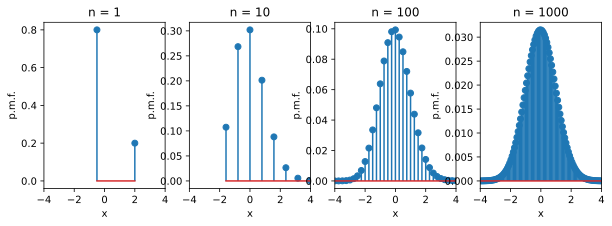

In [16]:
p = 0.2
ns = [1, 10, 100, 1000]
d2l.plt.figure(figsize=(10, 3))
for i in range(4):
    n = ns[i]
    pmf = torch.tensor([p**i * (1-p)**(n-i) * binom(n, i)
                        for i in range(n + 1)])
    d2l.plt.subplot(1, 4, i + 1)
    d2l.plt.stem([(i - n*p)/torch.sqrt(torch.tensor(n*p*(1 - p)))
                  for i in range(n + 1)], pmf,
                 use_line_collection=True)
    d2l.plt.xlim([-4, 4])
    d2l.plt.xlabel('x')
    d2l.plt.ylabel('p.m.f.')
    d2l.plt.title("n = {}".format(n))
d2l.plt.show()

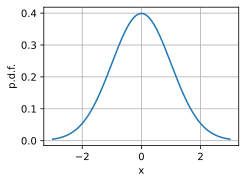

In [17]:
mu, sigma = 0, 1

x = torch.arange(-3, 3, 0.01)
p = 1 / torch.sqrt(2 * torch.pi * sigma**2) * torch.exp(
    -(x - mu)**2 / (2 * sigma**2))

d2l.plot(x, p, 'x', 'p.d.f.')

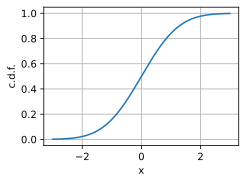

In [18]:
def phi(x):
    return (1.0 + erf((x - mu) / (sigma * torch.sqrt(torch.tensor(2.))))) / 2.0

d2l.plot(x, torch.tensor([phi(y) for y in x.tolist()]), 'x', 'c.d.f.')

In [19]:
torch.normal(mu, sigma, size=(10, 10))

tensor([[-1.5636, -0.3809, -0.9556, -0.0649, -0.5887, -1.2991,  0.6079, -0.1354,
         -0.3381,  0.3123],
        [-1.5095, -1.2016,  2.3016, -1.7119, -0.7756,  1.4258, -0.7223, -0.3069,
          1.5361,  0.7956],
        [ 0.4200, -0.2230, -0.2996, -0.8734, -0.9585, -0.4994,  1.0113, -1.6311,
         -1.7412, -0.0890],
        [-0.0485, -0.0711, -1.0632,  1.0648, -0.9416,  1.1586, -1.6611, -0.4980,
          0.4890,  0.6611],
        [ 1.2709, -0.7387,  0.6405, -0.3859, -1.6222, -1.7501,  0.2765,  1.2008,
          0.0824, -0.1369],
        [-0.2812, -0.9128, -0.1211, -1.0117,  0.3214, -0.9164, -1.2903, -0.4553,
         -2.5528, -0.1107],
        [ 0.2063, -0.2649, -0.4975, -0.9944, -1.9069,  1.2258,  0.3706,  0.1212,
          0.0252,  0.5283],
        [ 0.0883,  0.5663,  0.3139, -0.5647, -2.2350, -2.0577, -0.3458, -1.4179,
          0.7721,  0.1326],
        [ 0.7157, -1.0293,  0.0689,  0.6475, -0.9185,  1.8977,  1.2355, -0.5502,
         -0.8238,  1.9135],
        [-0.4223,  

#### 7. Exponential Family (Unifying Framework)

All distributions above belong to the **exponential family**, with density:

$$p(\mathbf{x} \mid \boldsymbol{\eta}) = h(\mathbf{x}) \cdot \exp\left(\boldsymbol{\eta}^\top T(\mathbf{x}) - A(\boldsymbol{\eta})\right)$$

**Components:**
| Component | Name | Description |
|-----------|------|-------------|
| $h(\mathbf{x})$ | Base measure | Original measure being modified |
| $\boldsymbol{\eta}$ | Natural parameters | Parameters that define the distribution |
| $T(\mathbf{x})$ | Sufficient statistics | Information needed to compute probability |
| $A(\boldsymbol{\eta})$ | Cumulant function | Normalization constant (log-partition) |

**Example: Gaussian as Exponential Family**
- Base measure: $h(x) = \frac{1}{\sqrt{2\pi}}$
- Natural parameters: $\boldsymbol{\eta} = \begin{bmatrix} \mu/\sigma^2 \\ 1/(2\sigma^2) \end{bmatrix}$
- Sufficient statistics: $T(x) = \begin{bmatrix} x \\ -x^2 \end{bmatrix}$

#### Distribution Comparison Table

| Distribution | Type | PMF/PDF | Mean | Variance |
|-------------|------|---------|------|----------|
| $\text{Bernoulli}(p)$ | Discrete | $p^x(1-p)^{1-x}$ | $p$ | $p(1-p)$ |
| $\text{Discrete Uniform}(n)$ | Discrete | $\frac{1}{n}$ | $\frac{n+1}{2}$ | $\frac{n^2-1}{12}$ |
| $\text{Continuous Uniform}(a,b)$ | Continuous | $\frac{1}{b-a}$ | $\frac{a+b}{2}$ | $\frac{(b-a)^2}{12}$ |
| $\text{Binomial}(n,p)$ | Discrete | $\binom{n}{k}p^k(1-p)^{n-k}$ | $np$ | $np(1-p)$ |
| $\text{Poisson}(\lambda)$ | Discrete | $\frac{\lambda^k e^{-\lambda}}{k!}$ | $\lambda$ | $\lambda$ |
| $\mathcal{N}(\mu, \sigma^2)$ | Continuous | $\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$ | $\mu$ | $\sigma^2$ |

#### Key Relationships Between Distributions

1. **Bernoulli → Binomial:** A $\text{Binomial}(n, p)$ is the sum of $n$ independent $\text{Bernoulli}(p)$ variables

2. **Binomial → Poisson:** As $n \to \infty$ and $p \to 0$ with $np = \lambda$ fixed, $\text{Binomial}(n, p) \to \text{Poisson}(\lambda)$

3. **Binomial → Gaussian (CLT):** As $n \to \infty$ with fixed $p$:
   $$\frac{X - np}{\sqrt{np(1-p)}} \xrightarrow{d} \mathcal{N}(0, 1)$$

4. **Central Limit Theorem (General):** For i.i.d. $X_i$ with mean $\mu$ and variance $\sigma^2$:
   $$\frac{\sum_{i=1}^N X_i - N\mu}{\sigma\sqrt{N}} \xrightarrow{d} \mathcal{N}(0, 1)$$

#### Applications in Machine Learning

| Distribution | ML Applications |
|-------------|-----------------|
| **Bernoulli** | Binary classification, dropout regularization, sigmoid output interpretation |
| **Binomial** | Multi-trial experiments, ensemble voting |
| **Poisson** | Count data, rare event modeling, attention mechanisms |
| **Gaussian** | Weight initialization, noise modeling, VAEs, likelihood functions, Gaussian processes |
| **Uniform** | Random initialization, data augmentation, sampling |
| **Exponential Family** | GLMs, probabilistic models, softmax outputs (categorical = exp family) |

#### Key Takeaways

1. **Gaussian is fundamental** due to the Central Limit Theorem - sums of many independent variables become approximately Gaussian

2. **Gaussian is maximum entropy** - given only mean and variance, it's the most "uncertain" (conservative) distribution choice

3. **Exponential family** provides a unified framework - most common distributions share this structure, enabling general optimization techniques

4. **Variance ≠ Mean** in general, but $\text{Var} = \text{Mean} = \lambda$ for Poisson (useful diagnostic)

============================= Naive Bayes =============================

#### The Classification Problem

**Goal:** Given features $\mathbf{x} \in \mathbb{R}^d$, predict the most likely label $y$:
$$\hat{y} = \mathrm{argmax}_y \, p(y \mid \mathbf{x})$$

**Challenge:** Directly estimating $p(y \mid \mathbf{x})$ requires exponentially many parameters — for $d$ binary features, we'd need $\mathcal{O}(2^d)$ parameters!

#### The Naive Bayes Solution

Apply **Bayes' theorem** to flip the conditioning:
$$\hat{y} = \mathrm{argmax}_y \, p(y \mid \mathbf{x}) = \mathrm{argmax}_y \, \frac{p(\mathbf{x} \mid y) p(y)}{p(\mathbf{x})} = \mathrm{argmax}_y \, p(\mathbf{x} \mid y) p(y)$$

The denominator $p(\mathbf{x})$ is constant across all $y$, so we can ignore it.

**The "Naive" Assumption — Conditional Independence:**

Assume features are conditionally independent given the label:
$$p(\mathbf{x} \mid y) = \prod_{i=1}^d p(x_i \mid y)$$

This reduces complexity from $\mathcal{O}(2^d n)$ to $\mathcal{O}(dn)$ parameters!

**Final Predictor:**
$$\hat{y} = \mathrm{argmax}_y \, p(y) \prod_{i=1}^d p(x_i \mid y)$$

#### Training: Estimating Parameters

**1. Class Prior $P_y[y] = p(y)$:**
$$p(y) = \frac{n_y}{n}$$
where $n_y$ = count of samples with label $y$, $n$ = total samples.

**2. Feature Likelihoods $P_{xy}[i, y] = p(x_i = 1 \mid y)$:**
$$p(x_i = 1 \mid y) = \frac{n_{iy} + 1}{n_y + 2}$$

The $+1$ and $+2$ are **Laplace smoothing** (add pseudo-counts) to avoid zero probabilities for unseen feature values. This can be motivated by a Beta-Binomial Bayesian prior.

#### Numerical Stability: Use Log-Probabilities

**Problem:** Multiplying many small probabilities causes numerical underflow:
$$\prod_{i=1}^{784} p(x_i \mid y) \approx 0 \quad \text{(underflow!)}$$

**Solution:** Work in log-space:
$$\hat{y} = \mathrm{argmax}_y \left[ \log p(y) + \sum_{i=1}^d \log p(x_i \mid y) \right]$$

For binary features:
$$\hat{y} = \mathrm{argmax}_y \left[ \log P_y[y] + \sum_{i=1}^d \left( t_i \log P_{xy}[i,y] + (1-t_i) \log(1 - P_{xy}[i,y]) \right) \right]$$

#### Key Properties

| Aspect | Description |
|--------|-------------|
| **Assumption** | Features are conditionally independent given class |
| **Complexity** | $\mathcal{O}(dn)$ parameters vs $\mathcal{O}(2^d n)$ without assumption |
| **Training** | Count frequencies + Laplace smoothing |
| **Inference** | Sum log-probabilities (avoid underflow) |
| **Works well when** | Features are approximately independent; high-dimensional sparse data |

#### Applications

- **Text classification** (spam detection, sentiment analysis) — words as binary features
- **Image classification** (digit recognition) — pixels as binary features  
- **Medical diagnosis** — symptoms as features
- **Baseline model** — simple, fast, interpretable benchmark

#### Key Takeaways

1. **Bayes' theorem** converts $p(y \mid \mathbf{x})$ to $p(\mathbf{x} \mid y) p(y)$, which is easier to estimate
2. **Conditional independence assumption** makes the problem tractable (exponential → linear)
3. **Laplace smoothing** prevents zero probabilities for unseen events
4. **Log-probabilities** avoid numerical underflow when multiplying many small numbers
5. Despite its "naive" assumption, works surprisingly well in practice, especially for text

In [1]:
%matplotlib inline
import math
import torch
import torchvision
from d2l import torch as d2l

d2l.use_svg_display()

In [2]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    lambda x: torch.floor(x * 255 / 128).squeeze(dim=0)
])

mnist_train = torchvision.datasets.MNIST(
    root='./temp', train=True, transform=data_transform, download=True)
mnist_test = torchvision.datasets.MNIST(
    root='./temp', train=False, transform=data_transform, download=True)

In [3]:
image, label = mnist_train[2]
image.shape, label

(torch.Size([28, 28]), 4)

In [4]:
print(image.shape, image.dtype)
print(label, type(label))

torch.Size([28, 28]) torch.float32
4 <class 'int'>


In [5]:
images = torch.stack([mnist_train[i][0] for i in range(10, 38)], dim=0)
labels = torch.tensor([mnist_train[i][1] for i in range(10, 38)])
images.shape, labels.shape

(torch.Size([28, 28, 28]), torch.Size([28]))

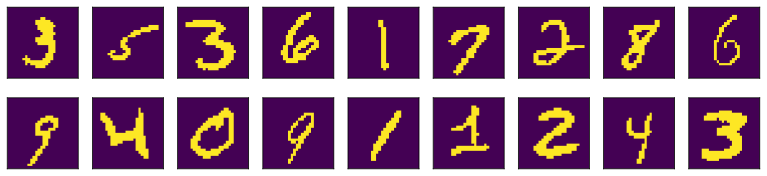

In [27]:
d2l.show_images(images, 2, 9);

In [7]:
X = torch.stack([mnist_train[i][0] for i in range(len(mnist_train))], dim=0)
Y = torch.tensor([mnist_train[i][1] for i in range(len(mnist_train))])

n_y = torch.zeros(10)
for y in range(10):
    n_y[y] = (Y == y).sum()
P_y = n_y / n_y.sum()
P_y

tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])

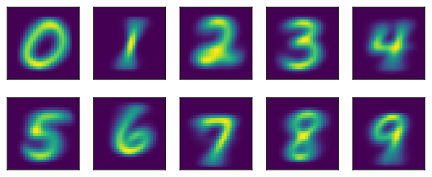

In [9]:
n_x = torch.zeros((10, 28, 28))
for y in range(10):
    n_x[y] = torch.tensor(X.numpy()[Y.numpy() == y].sum(axis=0))
P_xy = (n_x + 1) / (n_y + 2).reshape(10, 1, 1)

d2l.show_images(P_xy, 2, 5);

In [10]:
def bayes_pred(x):
    x = x.unsqueeze(0)  # (28, 28) -> (1, 28, 28)
    p_xy = P_xy * x + (1 - P_xy)*(1 - x)
    p_xy = p_xy.reshape(10, -1).prod(dim=1)  # p(x|y)
    return p_xy * P_y

image, label = mnist_test[0]
bayes_pred(image)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [11]:
a = 0.1
print('underflow:', a**784)
print('logarithm is normal:', 784*math.log(a))

underflow: 0.0
logarithm is normal: -1805.2267129073316


In [12]:
log_P_xy = torch.log(P_xy)
log_P_xy_neg = torch.log(1 - P_xy)
log_P_y = torch.log(P_y)

def bayes_pred_stable(x):
    x = x.unsqueeze(0)  # (28, 28) -> (1, 28, 28)
    p_xy = log_P_xy * x + log_P_xy_neg * (1 - x)
    p_xy = p_xy.reshape(10, -1).sum(axis=1)  # p(x|y)
    return p_xy + log_P_y

py = bayes_pred_stable(image)
py

tensor([-268.9725, -301.7044, -245.1951, -218.8738, -193.4570, -206.0909,
        -292.5226, -114.6257, -220.3313, -163.1784])

In [13]:
py.argmax(dim=0) == label

tensor(True)

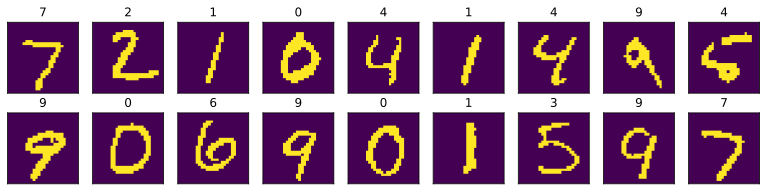

In [14]:
def predict(X):
    return [bayes_pred_stable(x).argmax(dim=0).type(torch.int32).item()
            for x in X]

X = torch.stack([mnist_test[i][0] for i in range(18)], dim=0)
y = torch.tensor([mnist_test[i][1] for i in range(18)])
preds = predict(X)
d2l.show_images(X, 2, 9, titles=[str(d) for d in preds]);

In [15]:
X = torch.stack([mnist_test[i][0] for i in range(len(mnist_test))], dim=0)
y = torch.tensor([mnist_test[i][1] for i in range(len(mnist_test))])
preds = torch.tensor(predict(X), dtype=torch.int32)
float((preds == y).sum()) / len(y)  # Validation accuracy

0.8427

### Evaluating and Comparing Estimators

Statistics provides the mathematical framework to discuss uncertainty in estimated values. When we have samples $x_1, \ldots, x_n$ drawn i.i.d. from some distribution, we want to estimate the true parameter $\theta$.

#### Estimator Definition
An **estimator** is a function of the data that produces an estimate:
$$\hat{\theta}_n = \hat{f}(x_1, \ldots, x_n)$$

**Examples:**
- For a Bernoulli random variable, the **maximum likelihood estimate** for the probability of success is the sample mean
- For a Gaussian, the sample mean estimates the true mean

#### Mean Squared Error (MSE)
The most common metric to evaluate estimators:
$$\text{MSE}(\hat{\theta}_n, \theta) = E[(\hat{\theta}_n - \theta)^2]$$

MSE measures the expected squared deviation between the estimator and the true value. Lower MSE indicates a better estimator.

#### Statistical Bias
The **bias** measures systematic error - how far off the estimator is on average:
$$\text{bias}(\hat{\theta}_n) = E(\hat{\theta}_n - \theta) = E(\hat{\theta}_n) - \theta$$

- **Unbiased estimator**: $E(\hat{\theta}_n) = \theta$ (bias = 0)
- **Biased estimator**: Consistently over- or under-estimates the true value
- Example: Sample mean is unbiased for the population mean

#### Variance and Standard Deviation
The **standard deviation** of an estimator measures its spread:
$$\sigma_{\hat{\theta}_n} = \sqrt{\text{Var}(\hat{\theta}_n)} = \sqrt{E[(\hat{\theta}_n - E(\hat{\theta}_n))^2]}$$

Note: This differs from MSE - variance measures deviation from the *expected value* of the estimator, not from the true parameter.

#### The Bias-Variance Tradeoff
A fundamental decomposition of MSE:
$$\text{MSE} = \text{Bias}^2 + \text{Variance}$$

**Interpretation:**
- Low bias & low variance → Best estimator (hard to achieve)
- High bias & low variance → Consistent but systematically wrong
- Low bias & high variance → Right on average but highly variable
- In practice, reducing one often increases the other

This tradeoff is central to model selection in machine learning: simple models have high bias but low variance; complex models have low bias but high variance.

### Conducting Hypothesis Tests

Hypothesis testing is a statistical framework for making decisions based on data, determining whether observed effects are statistically significant or could have occurred by chance.

#### Statistical Significance
The **significance level** $\alpha$ (commonly 0.05) controls the Type I error rate:
$$\text{Statistical Significance} = 1 - \alpha = 1 - P(\text{reject } H_0 \mid H_0 \text{ is true})$$

- **Type I Error (False Positive)**: Rejecting $H_0$ when it's actually true
- $\alpha = 0.05$ means we accept a 5% chance of falsely rejecting the null hypothesis

![Statistical Significant](./Images/22/statistical_significance.png)

#### Statistical Power
The **power** $(1 - \beta)$ measures the test's ability to detect true effects:
$$\text{Statistical Power} = 1 - \beta = 1 - P(\text{fail to reject } H_0 \mid H_0 \text{ is false})$$

- **Type II Error (False Negative)**: Failing to reject $H_0$ when it's actually false
- Higher power means better ability to detect real effects
- Power depends on: effect size, sample size, significance level, and variance

#### Test Statistic
A **test statistic** is a single number computed from data that summarizes the evidence against $H_0$. Examples:
- **z-statistic**: For known population variance
- **t-statistic**: For unknown population variance
- Test statistics follow known distributions under $H_0$

#### p-value
The **p-value** is the probability of observing a test statistic at least as extreme as what was observed, assuming $H_0$ is true:
$$p\text{-value} = P_{H_0}(T(X) \geq T(x))$$

**Decision rule:**
- If $p$-value $< \alpha$: Reject $H_0$ (result is statistically significant)
- If $p$-value $\geq \alpha$: Fail to reject $H_0$

**Important:** A small p-value does NOT mean the effect is large or important—only that it's unlikely to occur by chance.

#### One-sided vs Two-sided Tests
- **One-sided (one-tailed)**: Test if parameter is greater than (or less than) a value
  - $H_0: \mu = \mu_0$ vs $H_1: \mu > \mu_0$
- **Two-sided (two-tailed)**: Test if parameter differs from a value (either direction)
  - $H_0: \mu = \mu_0$ vs $H_1: \mu \neq \mu_0$
  - More conservative; critical region split between both tails

#### General Steps of Hypothesis Testing
1. **State the hypotheses**: Define $H_0$ (null) and $H_1$ (alternative)
2. **Choose significance level**: Typically $\alpha = 0.05$ or $0.01$
3. **Select appropriate test**: Based on data type and assumptions
4. **Calculate test statistic**: From the sample data
5. **Compute p-value**: Or compare to critical value
6. **Make decision**: Reject or fail to reject $H_0$
7. **Interpret results**: In context of the original question

### Constructing Confidence Intervals

Confidence intervals provide a range of plausible values for an unknown parameter, quantifying the uncertainty in point estimates.

#### Definition
A $(1-\alpha)$ **confidence interval** $C_n$ satisfies:
$$P_\theta(C_n \ni \theta) \geq 1 - \alpha, \quad \forall \theta$$

For example, a 95% confidence interval has $\alpha = 0.05$.

#### Correct Interpretation
**What a 95% CI means:**
- If we repeated the experiment many times and computed a CI each time, approximately 95% of those intervals would contain the true parameter
- The interval is random; the parameter is fixed

**What a 95% CI does NOT mean:**
- There is NOT a 95% probability that the true parameter lies in this specific interval
- The parameter is either in the interval or not—there's no probability involved once the interval is computed

#### A Gaussian Example
For samples $x_1, \ldots, x_n \sim \mathcal{N}(\mu, \sigma^2)$ with unknown $\mu$ and $\sigma^2$:

**Point estimates:**
$$\hat\mu_n = \frac{1}{n}\sum_{i=1}^n x_i \quad \text{(sample mean)}$$
$$\hat\sigma^2_n = \frac{1}{n-1}\sum_{i=1}^n (x_i - \hat\mu)^2 \quad \text{(sample variance, unbiased)}$$

**Test statistic:**
$$T = \frac{\hat\mu_n - \mu}{\hat\sigma_n/\sqrt{n}}$$

This follows a **t-distribution** with $n-1$ degrees of freedom (not a standard normal, because we estimate $\sigma$).

**Confidence interval for the mean:**
$$\left[\hat\mu_n - t_{\alpha/2, n-1} \cdot \frac{\hat\sigma_n}{\sqrt{n}}, \quad \hat\mu_n + t_{\alpha/2, n-1} \cdot \frac{\hat\sigma_n}{\sqrt{n}}\right]$$

where $t_{\alpha/2, n-1}$ is the critical value from the t-distribution.

#### Common Fallacies

**Fallacy 1: Narrow intervals = precise estimation**
- Narrow CIs indicate low variance in the estimator
- But the estimator could still be biased, systematically missing the true value
- Precision ≠ accuracy

**Fallacy 2: The true parameter is random**
- The true $\theta$ is a fixed (unknown) constant
- The randomness comes from the data and thus the interval
- Different samples → different intervals, but same true $\theta$

### Summary Table

| Concept | Formula | Interpretation |
|---------|---------|----------------|
| MSE | $E[(\hat{\theta}_n - \theta)^2]$ | Total expected squared error |
| Bias | $E(\hat{\theta}_n) - \theta$ | Systematic error |
| Variance | $E[(\hat{\theta}_n - E(\hat{\theta}_n))^2]$ | Spread of estimator |
| MSE Decomposition | $\text{Bias}^2 + \text{Variance}$ | Fundamental tradeoff |
| Significance | $1 - \alpha$ | Confidence in not making Type I error |
| Power | $1 - \beta$ | Ability to detect true effects |
| p-value | $P_{H_0}(T \geq t_{obs})$ | Evidence against null hypothesis |
| 95% CI | Interval containing $\theta$ with 95% coverage | Range of plausible values |

### Key Takeaways for Deep Learning

1. **Model evaluation** uses statistical estimators - training/validation accuracy are estimates with bias and variance
2. **Hyperparameter tuning** involves the bias-variance tradeoff - regularization increases bias but reduces variance
3. **A/B testing** in ML systems relies on hypothesis testing to compare model performance
4. **Confidence intervals** on metrics help quantify uncertainty in model performance claims
5. **Statistical power** matters when designing experiments to compare models - insufficient sample size leads to inconclusive results
6. **The bias-variance tradeoff** explains underfitting (high bias) vs overfitting (high variance) in model complexity

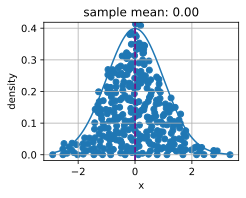

In [16]:
import torch
from d2l import torch as d2l

torch.pi = torch.acos(torch.zeros(1)) * 2  #define pi in torch

# Sample datapoints and create y coordinate
epsilon = 0.1
torch.manual_seed(8675309)
xs = torch.randn(size=(300,))

ys = torch.tensor(
    [torch.sum(torch.exp(-(xs[:i] - xs[i])**2 / (2 * epsilon**2))\
               / torch.sqrt(2*torch.pi*epsilon**2)) / len(xs)\
     for i in range(len(xs))])

# Compute true density
xd = torch.arange(torch.min(xs), torch.max(xs), 0.01)
yd = torch.exp(-xd**2/2) / torch.sqrt(2 * torch.pi)

# Plot the results
d2l.plot(xd, yd, 'x', 'density')
d2l.plt.scatter(xs, ys)
d2l.plt.axvline(x=0)
d2l.plt.axvline(x=torch.mean(xs), linestyle='--', color='purple')
d2l.plt.title(f'sample mean: {float(torch.mean(xs).item()):.2f}')
d2l.plt.show()

In [17]:
# Statistical bias
def stat_bias(true_theta, est_theta):
    return(torch.mean(est_theta) - true_theta)

# Mean squared error
def mse(data, true_theta):
    return(torch.mean(torch.square(data - true_theta)))

In [18]:
theta_true = 1
sigma = 4
sample_len = 10000
samples = torch.normal(theta_true, sigma, size=(sample_len, 1))
theta_est = torch.mean(samples)
theta_est

tensor(1.0170)

In [19]:
mse(samples, theta_true)

tensor(16.0298)

In [20]:
bias = stat_bias(theta_true, theta_est)
torch.square(samples.std(unbiased=False)) + torch.square(bias)

tensor(16.0298)

In [21]:
# PyTorch uses Bessel's correction by default, which means the use of ddof=1
# instead of default ddof=0 in numpy. We can use unbiased=False to imitate
# ddof=0.

# Number of samples
N = 1000

# Sample dataset
samples = torch.normal(0, 1, size=(N,))

# Lookup Students's t-distribution c.d.f.
t_star = 1.96

# Construct interval
mu_hat = torch.mean(samples)
sigma_hat = samples.std(unbiased=True)
(mu_hat - t_star*sigma_hat/torch.sqrt(torch.tensor(N, dtype=torch.float32)),\
 mu_hat + t_star*sigma_hat/torch.sqrt(torch.tensor(N, dtype=torch.float32)))

(tensor(-0.0568), tensor(0.0704))

======================== Information Theory ========================


### Overview

Information theory, pioneered by Claude E. Shannon in 1948, provides the mathematical foundation for quantifying, storing, and communicating information. It is fundamental to deep learning, particularly for understanding loss functions like cross-entropy.

### Information

#### Core Intuition
Information quantifies **how surprising** an event is:
- Rare events carry more information (high surprise)
- Common/certain events carry less information (low surprise)

**Card Example:**
- "I see a card" → 0 bits (certain event, no information)
- "I see a heart" → 2 bits ($\log_2(4) = 2$, 1 in 4 chance)
- "I see the 3 of spades" → ~5.7 bits ($\log_2(52) \approx 5.7$, 1 in 52 chance)
- "The deck is in this exact order" → ~225.6 bits ($\log_2(52!) \approx 225.6$)

#### Self-Information
The information content of an event with probability $p$ is:
$$I(X) = -\log_2(p)$$

**Properties:**
- Certain events ($p = 1$): $I(X) = 0$ bits
- Rare events ($p \to 0$): $I(X) \to \infty$ bits
- Measured in **bits** when using $\log_2$

**Example:** A binary code "0010" with equal probability for each bit:
$$I(\text{"0010"}) = -\log_2\left(\frac{1}{2^4}\right) = 4 \text{ bits}$$

#### Entropy

Entropy extends self-information from single events to entire probability distributions, measuring the **average information content** (or average surprise).

#### Motivating Entropy
Key axioms that uniquely define entropy:
1. Information from observing a random variable doesn't depend on variable name
2. Information from observing two independent random variables is the sum of individual informations
3. Observing (nearly) certain events provides (nearly) zero information

#### Definition
For a random variable $X$ with distribution $P$:
$$H(X) = -E_{x \sim P}[\log p(x)]$$

**Discrete case:**
$$H(X) = -\sum_i p_i \log p_i$$

**Continuous case:**
$$H(X) = -\int_x p(x) \log p(x) \, dx$$

#### Interpretations

**Why logarithm?**
- Makes entropy **additive** for independent variables: $H(X, Y) = H(X) + H(Y)$ if $X \perp Y$
- Turns products of probabilities into sums

**Why negative?**
- $\log(p)$ is negative for $p \in [0, 1]$
- Negation makes entropy non-negative (for discrete variables)

**Why expectation?**
- Entropy is the **average surprise** across all possible outcomes
- Weighted by how often each outcome occurs

#### Properties of Entropy

1. **Non-negativity** (discrete): $H(X) \geq 0$
   - Note: Continuous entropy can be negative!

2. **Lower bound for compression:**
   $$H(X) = -E_{x \sim P}[\log p(x)] \leq -E_{x \sim P}[\log q(x)]$$
   with equality iff $P = Q$. This means entropy gives the minimum average bits needed to encode data.

3. **Maximum entropy** (discrete with $k$ classes):
   $$H(X) \leq \log(k)$$
   with equality iff $p_i = \frac{1}{k}$ (uniform distribution)

4. **Maximum entropy** (continuous on $[0, 1]$):
   Achieved by the uniform distribution

### Mutual Information

Mutual information quantifies **shared information** between two random variables.

#### Joint Entropy
The entropy of a pair of random variables $(X, Y)$:
$$H(X, Y) = -E_{(x,y) \sim P}[\log p_{X,Y}(x, y)]$$

**Discrete:**
$$H(X, Y) = -\sum_x \sum_y p_{X,Y}(x, y) \log p_{X,Y}(x, y)$$

**Bounds:**
$$H(X), H(Y) \leq H(X, Y) \leq H(X) + H(Y)$$

- Lower bound: Achieved when $X = Y$ (identical variables)
- Upper bound: Achieved when $X \perp Y$ (independent variables)

#### Conditional Entropy
Information in $Y$ given knowledge of $X$:
$$H(Y \mid X) = -E_{(x,y) \sim P}[\log p(y \mid x)]$$

**Chain rule:**
$$H(Y \mid X) = H(X, Y) - H(X)$$

**Interpretation:** The information in $Y$ that is NOT already contained in $X$.

#### Mutual Information Definition
$$I(X, Y) = H(X, Y) - H(Y \mid X) - H(X \mid Y)$$

Alternatively:
$$I(X, Y) = E_x E_y \left[ p_{X,Y}(x, y) \log \frac{p_{X,Y}(x, y)}{p_X(x) p_Y(y)} \right]$$

**Visual relationship:**
$$
H(X,Y) = H(X) + H(Y) - I(X,Y)
       = H(X) + H(Y|X)
       = H(Y) + H(X|Y)
$$

#### Properties of Mutual Information

1. **Symmetric:** $I(X, Y) = I(Y, X)$
2. **Non-negative:** $I(X, Y) \geq 0$
3. **Independence:** $I(X, Y) = 0$ iff $X \perp Y$
4. **Self-information:** $I(X, X) = H(X)$
5. **Maximum:** If $Y = f(X)$ (deterministic function), then $I(X, Y) = H(Y) = H(X)$

#### Pointwise Mutual Information (PMI)
$$\text{pmi}(x, y) = \log \frac{p_{X,Y}(x, y)}{p_X(x) p_Y(y)}$$

**Interpretation:**
- $\text{pmi} > 0$: $x$ and $y$ co-occur more than expected by chance
- $\text{pmi} < 0$: $x$ and $y$ co-occur less than expected
- $\text{pmi} = 0$: $x$ and $y$ are independent

**Application:** Used in NLP to find word associations (e.g., "rain" and "forest" have high PMI in context of "Amazon rain forest")

### Kullback-Leibler (KL) Divergence

KL divergence measures how one probability distribution differs from another.

#### Definition
$$D_{KL}(P \| Q) = E_{x \sim P}\left[\log \frac{p(x)}{q(x)}\right]$$

Expanded:
$$D_{KL}(P \| Q) = \sum_x p(x) \log \frac{p(x)}{q(x)} = \sum_x p(x) \log p(x) - \sum_x p(x) \log q(x)$$

#### KL Divergence Properties

1. **Non-negative:** $D_{KL}(P \| Q) \geq 0$ (Gibbs' inequality)
2. **Zero iff equal:** $D_{KL}(P \| Q) = 0$ iff $P = Q$
3. **Asymmetric:** $D_{KL}(P \| Q) \neq D_{KL}(Q \| P)$ in general
   - Not a true distance metric!
4. **Unbounded:** Can be $\infty$ if $q(x) = 0$ where $p(x) > 0$

#### Interpretation
- Measures the **information lost** when using $Q$ to approximate $P$
- Or: Extra bits needed to encode samples from $P$ using a code optimized for $Q$

**Forward vs Reverse KL:**
- $D_{KL}(P \| Q)$: "Mode-seeking" — $Q$ is forced to cover where $P$ has mass
- $D_{KL}(Q \| P)$: "Mean-seeking" — $Q$ spreads to avoid areas where $P$ is zero

### Cross-Entropy

Cross-entropy is the most commonly used loss function in classification tasks.

#### Formal Definition
$$H(P, Q) = -E_{x \sim P}[\log q(x)]$$

**Discrete:**
$$H(P, Q) = -\sum_x p(x) \log q(x)$$

#### Relationship to KL Divergence and Entropy
$$H(P, Q) = H(P) + D_{KL}(P \| Q)$$

**Implications:**
- Cross-entropy ≥ Entropy (with equality iff $P = Q$)
- Minimizing cross-entropy = Minimizing KL divergence (when $P$ is fixed)
- Since $H(P)$ is constant for fixed true distribution $P$

#### Cross-Entropy for Multi-class Classification

**Setup:**
- True labels: One-hot encoded $\mathbf{y} = (y_1, \ldots, y_k)$ where $y_c = 1$ for correct class
- Predictions: Softmax outputs $\mathbf{\hat{y}} = (\hat{y}_1, \ldots, \hat{y}_k)$

**Cross-entropy loss:**
$$\mathcal{L} = -\sum_{i=1}^{k} y_i \log \hat{y}_i = -\log \hat{y}_c$$

(Simplifies because $y_i = 0$ for all $i \neq c$)

**Connection to Maximum Likelihood:**
- Maximizing log-likelihood of correct class = Minimizing cross-entropy
- For multi-class: $\max \sum_i \log \hat{y}_{c_i} = \min -\sum_i \log \hat{y}_{c_i}$

**Why cross-entropy for classification?**
1. Directly measures divergence between predicted and true distributions
2. Gradient is well-behaved: $\frac{\partial \mathcal{L}}{\partial \hat{y}_c} = \hat{y}_c - y_c$
3. Encourages confident correct predictions
4. Penalizes confident wrong predictions severely

### Summary Table

| Concept | Formula | Interpretation |
|---------|---------|----------------|
| Self-Information | $I(X) = -\log_2(p)$ | Surprise of single event |
| Entropy | $H(X) = -\sum p_i \log p_i$ | Average surprise / uncertainty |
| Joint Entropy | $H(X,Y) = -\sum\sum p_{xy} \log p_{xy}$ | Total information in pair |
| Conditional Entropy | $H(Y\|X) = H(X,Y) - H(X)$ | Information in $Y$ not in $X$ |
| Mutual Information | $I(X,Y) = H(X) + H(Y) - H(X,Y)$ | Shared information |
| KL Divergence | $D_{KL}(P\|Q) = \sum p \log(p/q)$ | Information lost using $Q$ for $P$ |
| Cross-Entropy | $H(P,Q) = -\sum p \log q$ | Expected bits using wrong code |

### Key Takeaways for Deep Learning

1. **Cross-entropy loss** is the standard for classification because it measures how different predicted probabilities are from true labels

2. **Minimizing cross-entropy = Minimizing KL divergence** between predicted and true distributions

3. **Information theory justifies** why we use log-probabilities in loss functions (additivity, numerical stability)

4. **Mutual information** is used in:
   - Feature selection (find features most informative about target)
   - Representation learning (maximize MI between input and learned representation)
   - InfoGAN, contrastive learning

5. **Entropy regularization** encourages exploration in reinforcement learning and prevents overconfident predictions

6. **KL divergence** is central to:
   - Variational autoencoders (VAE): KL term in ELBO
   - Knowledge distillation: Match student to teacher distribution
   - Bayesian deep learning: Measure divergence from prior